In [1]:
!pip install meteostat rasterio geopandas skorch torch tensorflow geohash2 h3 xarray rioxarray cdsapi netcdf4 h5netcdf catboost contextily xgboost lightgbm

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 370.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 266.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 348.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 507.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 291.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 509.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 314.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 320.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 242.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 257.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import pandas as pd
# Display all columns
pd.set_option('display.max_columns', None)

In [7]:
import pandas as pd
from rich.jupyter import display

# Load the VIIRS CSV
df_viirs = pd.read_csv("fire_nrt_J2V-C2_605414.csv")

# Convert date and time
df_viirs["acq_time"] = df_viirs["acq_time"].apply(lambda x: f"{int(x):04d}")
df_viirs["datetime"] = pd.to_datetime(df_viirs["acq_date"].astype(str) + " " +
                                      df_viirs["acq_time"].str[:2] + ":" +
                                      df_viirs["acq_time"].str[2:])

# View sample
df_viirs = df_viirs.drop('satellite', axis=1).drop('instrument', axis=1).drop('acq_date', axis=1).drop('acq_time', axis=1).drop('version', axis=1).drop('confidence', axis=1)

In [8]:
df_viirs

latitude  longitude  brightness  scan  track  bright_t31     frp  \
0       43.70303  -88.38511      297.58  0.36   0.57      272.11    0.80   
1       46.51368  -84.39453      313.19  0.48   0.48      273.17    1.83   
2       46.52116  -84.37431      297.91  0.48   0.48      273.98    2.33   
3       36.35433  -76.80997      303.37  0.40   0.37      281.62    2.00   
4       36.35509  -76.81439      295.91  0.40   0.37      280.05    0.45   
...          ...        ...         ...   ...    ...         ...     ...   
529140  19.40952 -155.29485      367.00  0.64   0.72      299.50  517.60   
529141  19.41197 -155.28418      367.00  0.64   0.72      323.01    0.00   
529142  19.41323 -155.27872      367.00  0.64   0.72      317.19  172.71   
529143  19.40295 -155.29382      367.00  0.64   0.72      358.59  517.60   
529144  19.40414 -155.28867      367.00  0.64   0.72      370.21    0.00   

       daynight            datetime  
0             N 2024-04-01 07:01:00  
1             N 2024-04-01 07:01:00  
2             N 2024-04-01 07:01:00  
3             N 2024-04-01 07:03:00  
4             N 2024-04-01 07:03:00  
...         ...                 ...  
529140        D 2025-04-01 22:42:00  
529141        D 2025-04-01 22:42:00  
529142        D 2025-04-01 22:42:00  
529143        D 2025-04-01 22:42:00  
529144        D 2025-04-01 22:42:00  

[529145 rows x 9 columns]

In [6]:
from datetime import datetime
from meteostat import Stations, Daily
import pandas as pd

# Date range
start = datetime(2024, 4, 1)
end = datetime(2025, 4, 1)

# Get top 20 weather stations in California
stations = Stations().region('US', 'CA').fetch(2000).reset_index()

# Create list to store data from all stations
weather_all = []

# Loop through each station
for idx, row in stations.iterrows():
    station_id = row['id']
    # print(f"Fetching weather data for {station_id} - {row['name']}")

    try:
        data = Daily(station_id, start, end).fetch()

        if not data.empty:
            data = data.copy()
            data['station_id'] = station_id
            data['station_name'] = row['name']
            data['latitude'] = row['latitude']
            data['longitude'] = row['longitude']
            data.reset_index(inplace=True)
            weather_all.append(data)
            # print(f"✅ Collected {len(data)} rows.")
    except Exception as e:
        print(f"⚠️ Error fetching data for {station_id}: {e}")


# Combine all data
weather_df = pd.concat(weather_all, ignore_index=True)

# Preview combined weather data
# weather_df

import geopandas as gpd
from shapely.geometry import Point

# Ensure latitude and longitude columns are present and valid
assert 'latitude' in weather_df.columns and 'longitude' in weather_df.columns

# Create geometry column from latitude and longitude
geometry = [Point(xy) for xy in zip(weather_df['longitude'], weather_df['latitude'])]

# Create GeoDataFrame
geo_weather_df = gpd.GeoDataFrame(weather_df, geometry=geometry)

# Set Coordinate Reference System (CRS) to WGS84 (EPSG:4326)
geo_weather_df.set_crs(epsg=4326, inplace=True)

# Display the GeoDataFrame
geo_weather_df

time  tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  \
0     2024-04-01  11.5   6.0  18.0   0.0   NaN  216.0  10.1   NaN  1017.1   
1     2024-04-02  11.9   6.0  18.0   0.0   NaN  339.0  10.7   NaN  1024.8   
2     2024-04-03  11.0   9.0  13.0   0.0   NaN  300.0  11.4   NaN  1021.5   
3     2024-04-04   8.4   6.0  11.0  11.8   NaN  236.0  19.3   NaN  1010.6   
4     2024-04-05   8.5   5.0  12.0   6.0   NaN  290.0  20.7   NaN  1014.2   
...          ...   ...   ...   ...   ...   ...    ...   ...   ...     ...   
53561 2025-03-28  13.0   8.9  18.5   0.0   NaN  243.0  31.8   NaN  1012.7   
53562 2025-03-29  12.7   7.4  19.6   0.0   NaN  238.0  26.7   NaN  1012.3   
53563 2025-03-30  12.6   7.6  19.2   1.4   NaN  203.0  28.5   NaN  1014.7   
53564 2025-03-31  13.9   9.1  20.9   0.0   NaN  210.0  31.0   NaN  1014.9   
53565 2025-04-01   9.3   6.0  13.8   0.0   NaN  269.0  33.1   NaN  1012.2   

       tsun station_id         station_name  latitude  longitude  \
0       NaN      69007    Fort Ord / Blanco   36.6815  -121.7617   
1       NaN      69007    Fort Ord / Blanco   36.6815  -121.7617   
2       NaN      69007    Fort Ord / Blanco   36.6815  -121.7617   
3       NaN      69007    Fort Ord / Blanco   36.6815  -121.7617   
4       NaN      69007    Fort Ord / Blanco   36.6815  -121.7617   
...     ...        ...                  ...       ...        ...   
53561   NaN      ZGK9P  Victorville Airport   34.5972  -117.3828   
53562   NaN      ZGK9P  Victorville Airport   34.5972  -117.3828   
53563   NaN      ZGK9P  Victorville Airport   34.5972  -117.3828   
53564   NaN      ZGK9P  Victorville Airport   34.5972  -117.3828   
53565   NaN      ZGK9P  Victorville Airport   34.5972  -117.3828   

                        geometry  
0      POINT (-121.7617 36.6815)  
1      POINT (-121.7617 36.6815)  
2      POINT (-121.7617 36.6815)  
3      POINT (-121.7617 36.6815)  
4      POINT (-121.7617 36.6815)  
...                          ...  
53561  POINT (-117.3828 34.5972)  
53562  POINT (-117.3828 34.5972)  
53563  POINT (-117.3828 34.5972)  
53564  POINT (-117.3828 34.5972)  
53565  POINT (-117.3828 34.5972)  

[53566 rows x 16 columns]

In [9]:
import rasterio
import geopandas as gpd
from shapely.geometry import Point

# Use your existing weather DataFrame
df = df_viirs[['latitude', 'longitude']].drop_duplicates().reset_index(drop=True)

# Convert to GeoDataFrame
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')

# Load NLCD raster (GeoTIFF)
raster_path = "land.tif"
raster = rasterio.open(raster_path)

viirs_gdf = gpd.GeoDataFrame(
    df_viirs,
    geometry=gpd.points_from_xy(df_viirs.longitude, df_viirs.latitude),
    crs="EPSG:4326"
)
gdf = viirs_gdf.copy()

# Reproject to raster's CRS
gdf = gdf.to_crs(raster.crs)

# Extract land cover values
coords = [(x, y) for x, y in zip(gdf.geometry.x, gdf.geometry.y)]
landcover_values = [val[0] for val in raster.sample(coords)]

# Add to GeoDataFrame
gdf['landcover'] = landcover_values

# Preview
gdf

latitude  longitude  brightness  scan  track  bright_t31     frp  \
0       43.70303  -88.38511      297.58  0.36   0.57      272.11    0.80   
1       46.51368  -84.39453      313.19  0.48   0.48      273.17    1.83   
2       46.52116  -84.37431      297.91  0.48   0.48      273.98    2.33   
3       36.35433  -76.80997      303.37  0.40   0.37      281.62    2.00   
4       36.35509  -76.81439      295.91  0.40   0.37      280.05    0.45   
...          ...        ...         ...   ...    ...         ...     ...   
529140  19.40952 -155.29485      367.00  0.64   0.72      299.50  517.60   
529141  19.41197 -155.28418      367.00  0.64   0.72      323.01    0.00   
529142  19.41323 -155.27872      367.00  0.64   0.72      317.19  172.71   
529143  19.40295 -155.29382      367.00  0.64   0.72      358.59  517.60   
529144  19.40414 -155.28867      367.00  0.64   0.72      370.21    0.00   

       daynight            datetime                          geometry  \
0             N 2024-04-01 07:01:00    POINT (610547.613 2325667.521)   
1             N 2024-04-01 07:01:00    POINT (891102.913 2668311.894)   
2             N 2024-04-01 07:01:00     POINT (892546.56 2669324.445)   
3             N 2024-04-01 07:03:00   POINT (1694837.441 1650124.252)   
4             N 2024-04-01 07:03:00   POINT (1694435.322 1650128.833)   
...         ...                 ...                               ...   
529140        D 2025-04-01 22:42:00  POINT (-6027196.881 1556333.222)   
529141        D 2025-04-01 22:42:00  POINT (-6026103.513 1555869.544)   
529142        D 2025-04-01 22:42:00  POINT (-6025543.615 1555632.875)   
529143        D 2025-04-01 22:42:00  POINT (-6027517.234 1555696.813)   
529144        D 2025-04-01 22:42:00  POINT (-6026989.012 1555473.626)   

        landcover  
0              31  
1             250  
2             250  
3              24  
4              22  
...           ...  
529140        250  
529141        250  
529142        250  
529143        250  
529144        250  

[529145 rows x 11 columns]

In [10]:
# NLCD Land Cover Legend
landcover_map = {
    11: 'Water',
    12: 'Snow/Ice',
    21: 'Developed, Open Space',
    22: 'Developed, Low Intensity',
    23: 'Developed, Medium Intensity',
    24: 'Developed, High Intensity',
    31: 'Barren Land',
    41: 'Deciduous Forest',
    42: 'Evergreen Forest',
    43: 'Mixed Forest',
    52: 'Shrub/Scrub',
    71: 'Grassland/Herbaceous',
    81: 'Pasture/Hay',
    82: 'Cultivated Crops',
    90: 'Woody Wetlands',
    95: 'Emergent Herbaceous Wetlands',
    250: 'Other/Unknown'  # Custom or reclassified value
}

# Fire risk classification
def get_fire_risk(code):
    high_risk = [42, 52, 71]                    # Evergreen, Shrubland, Grassland
    medium_risk = [41, 43]                      # Deciduous and Mixed Forests
    low_risk = [81, 82]                         # Pasture/Crops
    very_low_risk = [11, 12, 21, 22, 23, 24, 31, 90, 95]  # Water, Snow, Urban, Barren, Wetlands
    unknown_risk = [250]                        # Custom/uncertain class

    if code in high_risk:
        return 'High'
    elif code in medium_risk:
        return 'Medium'
    elif code in low_risk:
        return 'Low'
    elif code in very_low_risk:
        return 'Very Low'
    elif code in unknown_risk:
        return 'Unknown'
    else:
        return 'Very Low'  # Default catch-all

# Apply mappings to your GeoDataFrame
gdf['landcover_name'] = gdf['landcover'].map(landcover_map)
gdf['fire_risk'] = gdf['landcover'].apply(get_fire_risk)

# Preview
gdf

latitude  longitude  brightness  scan  track  bright_t31     frp  \
0       43.70303  -88.38511      297.58  0.36   0.57      272.11    0.80   
1       46.51368  -84.39453      313.19  0.48   0.48      273.17    1.83   
2       46.52116  -84.37431      297.91  0.48   0.48      273.98    2.33   
3       36.35433  -76.80997      303.37  0.40   0.37      281.62    2.00   
4       36.35509  -76.81439      295.91  0.40   0.37      280.05    0.45   
...          ...        ...         ...   ...    ...         ...     ...   
529140  19.40952 -155.29485      367.00  0.64   0.72      299.50  517.60   
529141  19.41197 -155.28418      367.00  0.64   0.72      323.01    0.00   
529142  19.41323 -155.27872      367.00  0.64   0.72      317.19  172.71   
529143  19.40295 -155.29382      367.00  0.64   0.72      358.59  517.60   
529144  19.40414 -155.28867      367.00  0.64   0.72      370.21    0.00   

       daynight            datetime                          geometry  \
0             N 2024-04-01 07:01:00    POINT (610547.613 2325667.521)   
1             N 2024-04-01 07:01:00    POINT (891102.913 2668311.894)   
2             N 2024-04-01 07:01:00     POINT (892546.56 2669324.445)   
3             N 2024-04-01 07:03:00   POINT (1694837.441 1650124.252)   
4             N 2024-04-01 07:03:00   POINT (1694435.322 1650128.833)   
...         ...                 ...                               ...   
529140        D 2025-04-01 22:42:00  POINT (-6027196.881 1556333.222)   
529141        D 2025-04-01 22:42:00  POINT (-6026103.513 1555869.544)   
529142        D 2025-04-01 22:42:00  POINT (-6025543.615 1555632.875)   
529143        D 2025-04-01 22:42:00  POINT (-6027517.234 1555696.813)   
529144        D 2025-04-01 22:42:00  POINT (-6026989.012 1555473.626)   

        landcover             landcover_name fire_risk  
0              31                Barren Land  Very Low  
1             250              Other/Unknown   Unknown  
2             250              Other/Unknown   Unknown  
3              24  Developed, High Intensity  Very Low  
4              22   Developed, Low Intensity  Very Low  
...           ...                        ...       ...  
529140        250              Other/Unknown   Unknown  
529141        250              Other/Unknown   Unknown  
529142        250              Other/Unknown   Unknown  
529143        250              Other/Unknown   Unknown  
529144        250              Other/Unknown   Unknown  

[529145 rows x 13 columns]

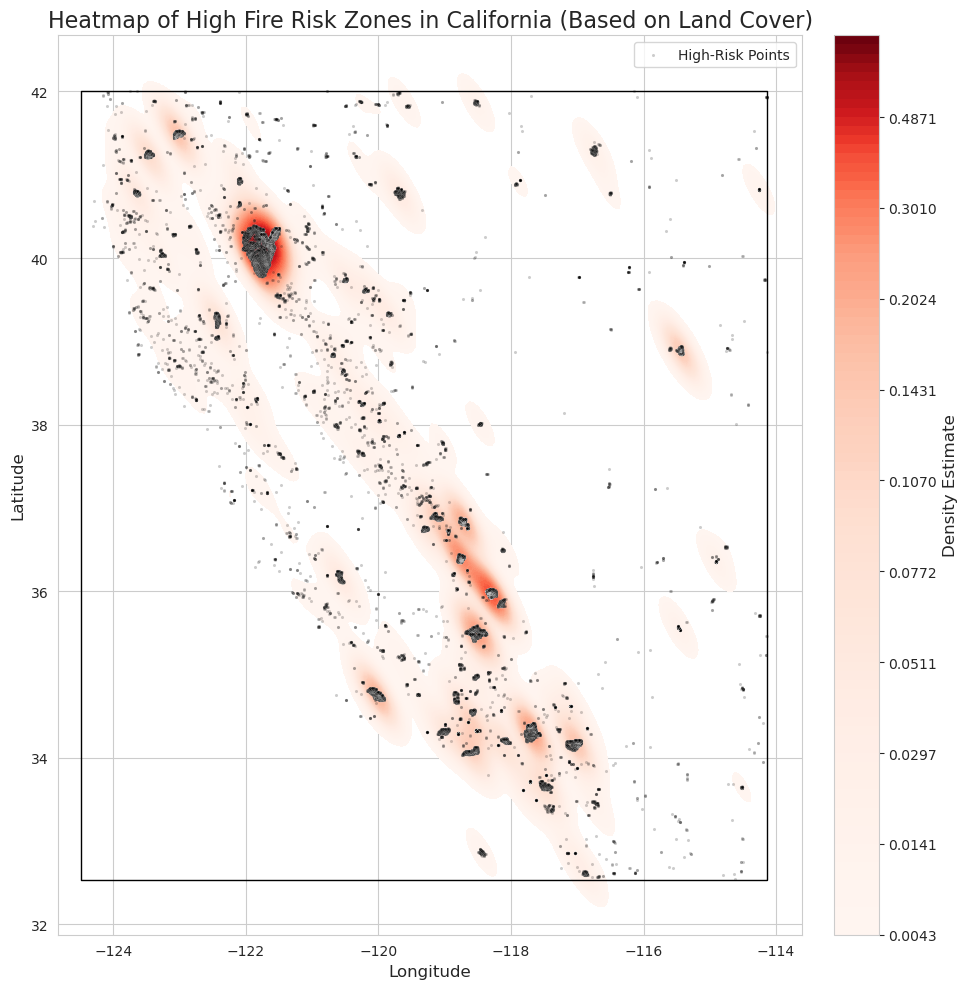

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from shapely.geometry import box

# Ensure data is in lat/lon
gdf = gdf.to_crs(epsg=4326)

# Filter only high-risk zones
high_risk = gdf[gdf['fire_risk'] == 'High'].copy()
high_risk['longitude'] = high_risk.geometry.x
high_risk['latitude'] = high_risk.geometry.y

# Define California bounding box and clip
ca_bounds = (-124.48, 32.53, -114.13, 42.01)
ca_box = box(*ca_bounds)
ca_gdf = gpd.GeoDataFrame({'geometry': [ca_box]}, crs='EPSG:4326')
high_risk_ca = gpd.clip(high_risk, ca_gdf)

# Set Seaborn style
sns.set_style("whitegrid")

# Plot
plt.figure(figsize=(16, 10))
ax = sns.kdeplot(
    x=high_risk_ca['longitude'],
    y=high_risk_ca['latitude'],
    cmap="Reds",
    fill=True,
    bw_adjust=0.5,
    thresh=0.05,
    levels=100
)

# Overlay scatter of actual points
sns.scatterplot(
    x=high_risk_ca['longitude'],
    y=high_risk_ca['latitude'],
    color='black',
    s=5,
    alpha=0.2,
    label='High-Risk Points',
    ax=ax
)

# Plot California boundary
ca_gdf.boundary.plot(ax=ax, color='black', linewidth=1)

# Titles and labels
plt.title("Heatmap of High Fire Risk Zones in California (Based on Land Cover)", fontsize=16)
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)

# Color bar
colorbar = plt.colorbar(ax.collections[0], ax=ax, orientation="vertical", pad=0.02)
colorbar.set_label("Density Estimate", fontsize=12)

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [10]:
# pip install earthengine-api
# earthengine authenticate

In [11]:
# import ee
# ee.Initialize(project='gee-wildfire-project')

# # Time range
# start_date = '2024-04-01'
# end_date = '2025-04-01'

# # New MODIS Collection
# modis_ndvi = ee.ImageCollection("MODIS/061/MOD13Q1") \
#     .filterDate(start_date, end_date) \
#     .select('NDVI') \
#     .mean()

# # California boundary
# california = ee.FeatureCollection("TIGER/2018/States") \
#     .filter(ee.Filter.eq('NAME', 'California'))

# # Clip NDVI to California
# ndvi_california = modis_ndvi.clip(california)

# # Export to Drive
# task = ee.batch.Export.image.toDrive(
#     image=ndvi_california,
#     description='NDVI_California_2024',
#     folder='EarthEngine',
#     fileNamePrefix='NDVI_CA_2024',
#     scale=250,
#     region=california.geometry(),
#     fileFormat='GeoTIFF'
# )
# task.start()

In [12]:
# task.status()

In [11]:
import rasterio
import geopandas as gpd
from shapely.geometry import Point

# Load the GeoTIFF
raster_path = "NDVI_CA_2024.tif"
raster = rasterio.open(raster_path)

gdf_prev = gdf.copy()

# Reproject to match raster CRS
gdf = gdf_prev.to_crs(raster.crs)

# Extract coordinates
coords = [(geom.x, geom.y) for geom in gdf.geometry]

# Sample raster values at those coords
ndvi_values = [val[0] for val in raster.sample(coords)]

# Add to DataFrame
gdf['ndvi'] = ndvi_values

gdf = gdf[gdf['landcover'] != 250]

# Preview
gdf

latitude  longitude  brightness  scan  track  bright_t31   frp  \
0       43.70303  -88.38511      297.58  0.36   0.57      272.11  0.80   
3       36.35433  -76.80997      303.37  0.40   0.37      281.62  2.00   
4       36.35509  -76.81439      295.91  0.40   0.37      280.05  0.45   
5       36.35580  -76.80739      331.55  0.40   0.37      282.06  4.80   
6       37.27381  -79.99678      310.11  0.40   0.37      273.75  1.80   
...          ...        ...         ...   ...    ...         ...   ...   
529073  46.37429 -118.74744      336.31  0.52   0.42      292.30  5.52   
529074  46.71207 -119.05591      333.69  0.51   0.41      288.78  9.07   
529075  46.71137 -119.06264      335.35  0.51   0.41      290.46  9.51   
529076  46.71198 -119.05543      330.18  0.51   0.41      288.23  8.95   
529077  46.71131 -119.06216      342.38  0.51   0.41      291.03  8.95   

       daynight            datetime                     geometry  landcover  \
0             N 2024-04-01 07:01:00   POINT (-88.38511 43.70303)         31   
3             N 2024-04-01 07:03:00   POINT (-76.80997 36.35433)         24   
4             N 2024-04-01 07:03:00   POINT (-76.81439 36.35509)         22   
5             N 2024-04-01 07:03:00    POINT (-76.80739 36.3558)         31   
6             N 2024-04-01 07:03:00   POINT (-79.99678 37.27381)         23   
...         ...                 ...                          ...        ...   
529073        D 2025-04-01 21:08:00  POINT (-118.74744 46.37429)         82   
529074        D 2025-04-01 21:08:00  POINT (-119.05591 46.71207)         82   
529075        D 2025-04-01 21:08:00  POINT (-119.06264 46.71137)         82   
529076        D 2025-04-01 21:08:00  POINT (-119.05543 46.71198)         82   
529077        D 2025-04-01 21:08:00  POINT (-119.06216 46.71131)         82   

                     landcover_name fire_risk  ndvi  
0                       Barren Land  Very Low   0.0  
3         Developed, High Intensity  Very Low   0.0  
4          Developed, Low Intensity  Very Low   0.0  
5                       Barren Land  Very Low   0.0  
6       Developed, Medium Intensity  Very Low   0.0  
...                             ...       ...   ...  
529073             Cultivated Crops       Low   0.0  
529074             Cultivated Crops       Low   0.0  
529075             Cultivated Crops       Low   0.0  
529076             Cultivated Crops       Low   0.0  
529077             Cultivated Crops       Low   0.0  

[508265 rows x 14 columns]

In [ ]:
# Exclude geometry column for this summary
eda_summary = gdf.drop(columns='geometry', errors='ignore').apply(
    lambda col: pd.Series({
        'null_count': col.isnull().sum(),
        'unique_count': col.nunique()
    })
)

# Optional: sort by nulls or unique values
eda_summary = eda_summary.T.sort_values(by='null_count', ascending=False)

# Display the result
import pandas as pd
from IPython.display import display
display(eda_summary)

In [13]:
gdf = gdf.dropna(subset=['ndvi'])

In [ ]:
nodata_val = raster.nodata or -9999
gdf['ndvi'] = [np.nan if val == nodata_val else val for val in ndvi_values]

gdf['ndvi'] = gdf['ndvi'].clip(lower=-1, upper=1)

In [ ]:
gdf

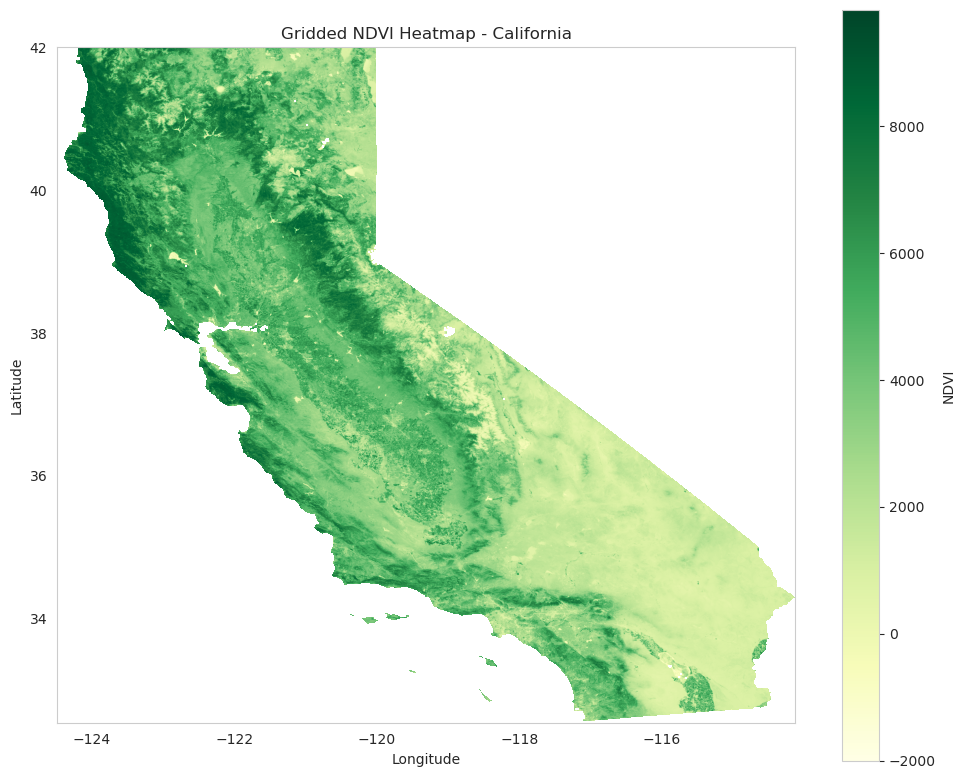

In [20]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from rasterio.plot import plotting_extent

# Load NDVI GeoTIFF
raster_path = "NDVI_CA_2024.tif"

with rasterio.open(raster_path) as src:
    ndvi_data = src.read(1).astype(float)
    ndvi_data[ndvi_data == src.nodata] = np.nan
    extent = plotting_extent(src)  # Fixed line

# Plot NDVI heatmap
plt.figure(figsize=(10, 8))
plt.imshow(ndvi_data, cmap='YlGn', extent=extent, origin='upper')
plt.title("Gridded NDVI Heatmap - California")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="NDVI")
plt.grid(False)
plt.tight_layout()
plt.show()


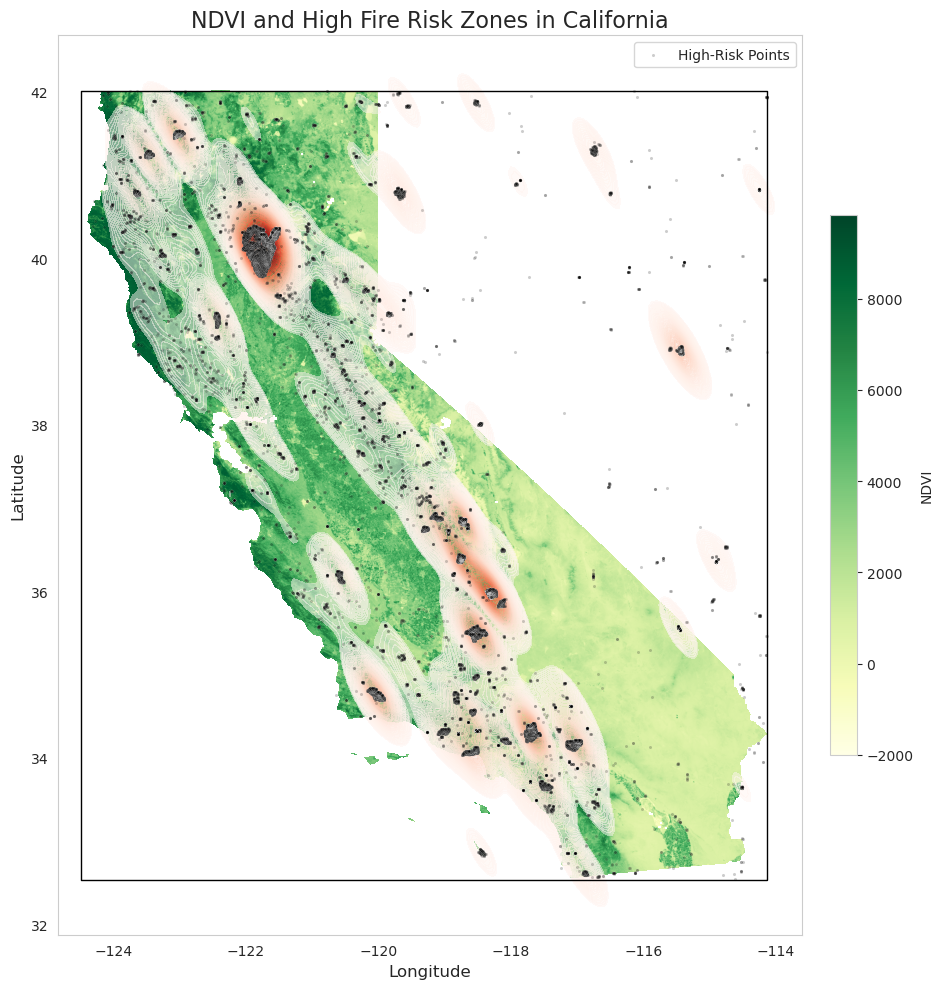

In [41]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd
import seaborn as sns
from shapely.geometry import box
from rasterio.plot import plotting_extent

# Load fire risk GeoDataFrame and make sure it's in EPSG:4326
gdf = gdf.to_crs(epsg=4326)

# Filter only high-risk zones and extract coordinates
high_risk = gdf[gdf['fire_risk'] == 'High'].copy()
high_risk['longitude'] = high_risk.geometry.x
high_risk['latitude'] = high_risk.geometry.y

# Define California bounding box and clip data
ca_bounds = (-124.48, 32.53, -114.13, 42.01)
ca_box = box(*ca_bounds)
ca_gdf = gpd.GeoDataFrame({'geometry': [ca_box]}, crs='EPSG:4326')
high_risk_ca = gpd.clip(high_risk, ca_gdf)

# Load NDVI raster (GeoTIFF)
raster_path = "NDVI_CA_2024.tif"
with rasterio.open(raster_path) as src:
    ndvi_data = src.read(1).astype(float)
    ndvi_data[ndvi_data == src.nodata] = np.nan
    extent = plotting_extent(src)

# Plot NDVI as basemap
plt.figure(figsize=(14, 10))
plt.imshow(ndvi_data, cmap='YlGn', extent=extent, origin='upper')
plt.title("NDVI and High Fire Risk Zones in California", fontsize=16)
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.colorbar(label="NDVI", shrink=0.6, pad=0.02)

# Overlay KDE plot for fire risk density
sns.kdeplot(
    x=high_risk_ca['longitude'],
    y=high_risk_ca['latitude'],
    cmap="Reds",
    fill=True,
    bw_adjust=0.5,
    thresh=0.05,
    levels=100,
    alpha=0.5,
    linewidths=0
)

# Optional: overlay points
sns.scatterplot(
    x=high_risk_ca['longitude'],
    y=high_risk_ca['latitude'],
    color='black',
    s=5,
    alpha=0.2,
    label='High-Risk Points'
)

# California boundary for reference
ca_gdf.boundary.plot(ax=plt.gca(), color='black', linewidth=1)

# Final layout
plt.legend(loc='upper right')
plt.grid(False)
plt.tight_layout()
plt.show()

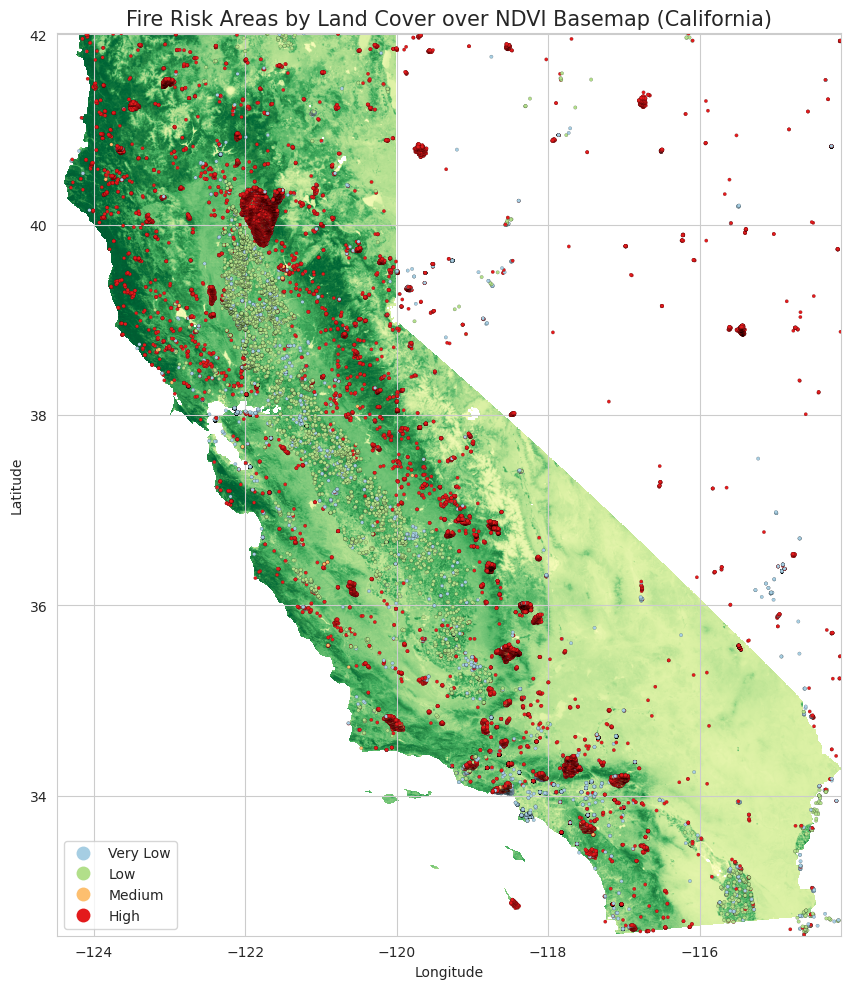

In [45]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import rasterio
import numpy as np
from rasterio.plot import plotting_extent
from matplotlib.colors import ListedColormap
from shapely.geometry import box

# Define custom colors for each risk level
colors = ['#a6cee3', '#b2df8a', '#fdbf6f', '#e31a1c']  # Very Low → High
cmap = ListedColormap(colors)

# Define risk level ordering
risk_order = ['Very Low', 'Low', 'Medium', 'High']
gdf['fire_risk'] = pd.Categorical(gdf['fire_risk'], categories=risk_order, ordered=True)

# Ensure geographic CRS for consistency
gdf = gdf.to_crs(epsg=4326)

# Define California bounding box
ca_bounds = (-124.48, 32.53, -114.13, 42.01)
ca_box = box(*ca_bounds)
ca_gdf = gpd.GeoDataFrame({'geometry': [ca_box]}, crs='EPSG:4326')
gdf_ca = gpd.clip(gdf, ca_gdf)

# Load NDVI raster
raster_path = "NDVI_CA_2024.tif"
with rasterio.open(raster_path) as src:
    ndvi_data = src.read(1).astype(float)
    ndvi_data[ndvi_data == src.nodata] = np.nan
    extent = plotting_extent(src)

# Plot
fig, ax = plt.subplots(figsize=(12, 10))

# NDVI basemap
ax.imshow(ndvi_data, cmap='YlGn', extent=extent, origin='upper', zorder=0)

# Overlay fire risk zones
gdf_ca.plot(ax=ax, column='fire_risk', legend=True, cmap=cmap, markersize=6, zorder=1, edgecolor='k', linewidth=0.1)

# Title and formatting
plt.title("Fire Risk Areas by Land Cover over NDVI Basemap (California)", fontsize=15)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
import os
import glob
import xarray as xr
import rioxarray
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
from tqdm import tqdm
from datetime import datetime, timedelta

era5_folder = "era5_data"
era5_files = sorted(glob.glob(f"{era5_folder}/era5_*.nc"))
print(f"Found {len(era5_files)} ERA5 files.")

all_era5_data = []

# Loop through each ERA5 monthly file
for file_path in tqdm(era5_files, desc="Processing ERA5 files"):
    try:
        ds = xr.open_dataset(file_path)
        ds = ds.rio.write_crs("EPSG:4326")  # Ensure CRS

        # Extract all days at 12:00 UTC
        noon_times = [t for t in ds.valid_time.values if pd.to_datetime(t).hour == 12]

        for t in noon_times:
            date = pd.to_datetime(t).date()

            # Extract and process variables for this day
            try:
                temp = (ds['t2m'].sel(valid_time=t) - 273.15)  # K → °C
                u10 = ds['u10'].sel(valid_time=t)
                v10 = ds['v10'].sel(valid_time=t)

                # Create meshgrid
                lons, lats = np.meshgrid(temp['longitude'].values, temp['latitude'].values)
                temp_vals = temp.values
                u_vals = u10.values
                v_vals = v10.values

                # Flatten and mask
                lons_flat = lons.ravel()
                lats_flat = lats.ravel()
                temp_flat = temp_vals.ravel()
                u_flat = u_vals.ravel()
                v_flat = v_vals.ravel()

                mask = ~np.isnan(temp_flat)

                df = pd.DataFrame({
                    "date": date,
                    "lon": lons_flat[mask],
                    "lat": lats_flat[mask],
                    "temp": temp_flat[mask],
                    "u_wind": u_flat[mask],
                    "v_wind": v_flat[mask]
                })
                df["geometry"] = gpd.points_from_xy(df["lon"], df["lat"])
                df["wind_speed"] = np.sqrt(df["u_wind"]**2 + df["v_wind"]**2)

                all_era5_data.append(df)
            except Exception as e:
                print(f"Error processing date {date}: {e}")
                continue

    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        continue

# Combine and convert to GeoDataFrame
era5_gdf = gpd.GeoDataFrame(pd.concat(all_era5_data, ignore_index=True), crs="EPSG:4326")

# Save to file
era5_gdf.to_parquet("era5_timeseries_fast.parquet")
print("✅ ERA5 GeoDataFrame saved to era5_timeseries_fast.parquet")

Found 13 ERA5 files.


Processing ERA5 files: 100%|██████████| 13/13 [00:03<00:00,  3.46it/s]


✅ ERA5 GeoDataFrame saved to era5_timeseries_fast.parquet


In [18]:
ds = xr.open_dataset("era5_data/era5_2024_04.nc")
print(ds.data_vars.keys())

KeysView(Data variables:
    t2m      (valid_time, latitude, longitude) float32 5MB ...
    u10      (valid_time, latitude, longitude) float32 5MB ...
    v10      (valid_time, latitude, longitude) float32 5MB ...)


In [19]:
era5_gdf

date     lon   lat       temp    u_wind     v_wind  \
0       2024-04-01 -125.00  42.0  11.039948  0.627289 -10.667358   
1       2024-04-01 -124.75  42.0  11.172760  0.502289  -9.517944   
2       2024-04-01 -124.50  42.0  10.797760 -0.216461  -7.146851   
3       2024-04-01 -124.25  42.0   8.670807 -2.219391  -3.088257   
4       2024-04-01 -124.00  42.0   5.256744 -2.474274  -1.196655   
...            ...     ...   ...        ...       ...        ...   
706630  2025-04-18 -115.00  32.0  12.974762  2.458145   1.201225   
706631  2025-04-18 -114.75  32.0  13.709137  2.613419   0.187553   
706632  2025-04-18 -114.50  32.0  14.254059  2.334122  -0.959908   
706633  2025-04-18 -114.25  32.0  13.332184  1.707169  -1.850533   
706634  2025-04-18 -114.00  32.0  14.273590  1.492325  -1.931587   

                  geometry  wind_speed  
0          POINT (-125 42)   10.685786  
1       POINT (-124.75 42)    9.531189  
2        POINT (-124.5 42)    7.150128  
3       POINT (-124.25 42)    3.803029  
4          POINT (-124 42)    2.748457  
...                    ...         ...  
706630     POINT (-115 32)    2.735950  
706631  POINT (-114.75 32)    2.620140  
706632   POINT (-114.5 32)    2.523796  
706633  POINT (-114.25 32)    2.517716  
706634     POINT (-114 32)    2.440914  

[706635 rows x 8 columns]

In [20]:
import geopandas as gpd
import pandas as pd
from tqdm.auto import tqdm
from shapely.geometry import Point

# Ensure both GeoDataFrames are in the same CRS
gdf = gdf.to_crs("EPSG:4326")
era5_gdf = era5_gdf.to_crs("EPSG:4326")

# Extract date fields
gdf['date'] = gdf['datetime'].dt.date
era5_gdf['date'] = pd.to_datetime(era5_gdf['date']).dt.date

# Index ERA5 data by date
era5_by_date = {d: group for d, group in era5_gdf.groupby('date')}

# Initialize output list
joined_rows = []

# Create tqdm progress bar
unique_dates = gdf['date'].unique()
progress = tqdm(unique_dates, desc="Matching fire & weather by date", ncols=500)

# Loop with spatial join per day
for date_val in progress:
    if date_val not in era5_by_date:
        continue

    daily_fire = gdf[gdf['date'] == date_val]
    daily_weather = era5_by_date[date_val]

    if daily_fire.empty or daily_weather.empty:
        continue

    joined = gpd.sjoin_nearest(
        daily_fire,
        daily_weather,
        how='left',
        distance_col='spatial_dist',
        max_distance=10000  # 10 km
    )
    joined_rows.append(joined)

# Concatenate results
combined_gdf = pd.concat(joined_rows, ignore_index=True)

# Drop rows missing key features
combined_gdf = combined_gdf.dropna(subset=['ndvi', 'temp'])

# Summary
print(f"✅ Combined GeoDataFrame shape: {combined_gdf.shape}")

Matching fire & weather by date:   0%|                                                                        …

/opt/conda/lib/python3.11/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/opt/conda/lib/python3.11/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/opt/conda/lib/python3.11/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/opt/conda/lib/python3.11/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' t

✅ Combined GeoDataFrame shape: (504445, 24)


In [21]:
display(combined_gdf)

latitude  longitude  brightness  scan  track  bright_t31   frp  \
0       43.70303  -88.38511      297.58  0.36   0.57      272.11  0.80   
1       36.35433  -76.80997      303.37  0.40   0.37      281.62  2.00   
2       36.35509  -76.81439      295.91  0.40   0.37      280.05  0.45   
3       36.35580  -76.80739      331.55  0.40   0.37      282.06  4.80   
4       37.27381  -79.99678      310.11  0.40   0.37      273.75  1.80   
...          ...        ...         ...   ...    ...         ...   ...   
504440  46.37429 -118.74744      336.31  0.52   0.42      292.30  5.52   
504441  46.71207 -119.05591      333.69  0.51   0.41      288.78  9.07   
504442  46.71137 -119.06264      335.35  0.51   0.41      290.46  9.51   
504443  46.71198 -119.05543      330.18  0.51   0.41      288.23  8.95   
504444  46.71131 -119.06216      342.38  0.51   0.41      291.03  8.95   

       daynight            datetime                     geometry  landcover  \
0             N 2024-04-01 07:01:00   POINT (-88.38511 43.70303)         31   
1             N 2024-04-01 07:03:00   POINT (-76.80997 36.35433)         24   
2             N 2024-04-01 07:03:00   POINT (-76.81439 36.35509)         22   
3             N 2024-04-01 07:03:00    POINT (-76.80739 36.3558)         31   
4             N 2024-04-01 07:03:00   POINT (-79.99678 37.27381)         23   
...         ...                 ...                          ...        ...   
504440        D 2025-04-01 21:08:00  POINT (-118.74744 46.37429)         82   
504441        D 2025-04-01 21:08:00  POINT (-119.05591 46.71207)         82   
504442        D 2025-04-01 21:08:00  POINT (-119.06264 46.71137)         82   
504443        D 2025-04-01 21:08:00  POINT (-119.05543 46.71198)         82   
504444        D 2025-04-01 21:08:00  POINT (-119.06216 46.71131)         82   

                     landcover_name fire_risk  ndvi   date_left  index_right  \
0                       Barren Land  Very Low   0.0  2024-04-01           44   
1         Developed, High Intensity  Very Low   0.0  2024-04-01         1079   
2          Developed, Low Intensity  Very Low   0.0  2024-04-01         1079   
3                       Barren Land  Very Low   0.0  2024-04-01         1079   
4       Developed, Medium Intensity  Very Low   0.0  2024-04-01          899   
...                             ...       ...   ...         ...          ...   
504440             Cultivated Crops       Low   0.0  2025-04-01       673450   
504441             Cultivated Crops       Low   0.0  2025-04-01       673449   
504442             Cultivated Crops       Low   0.0  2025-04-01       673449   
504443             Cultivated Crops       Low   0.0  2025-04-01       673449   
504444             Cultivated Crops       Low   0.0  2025-04-01       673449   

        date_right     lon    lat      temp    u_wind    v_wind  wind_speed  \
0       2024-04-01 -114.00  42.00 -4.401459  1.142914 -1.281616    1.717205   
1       2024-04-01 -114.00  36.25  9.153229 -0.688141 -0.562866    0.889020   
2       2024-04-01 -114.00  36.25  9.153229 -0.688141 -0.562866    0.889020   
3       2024-04-01 -114.00  36.25  9.153229 -0.688141 -0.562866    0.889020   
4       2024-04-01 -114.00  37.25  7.389557  0.574554 -0.197632    0.607595   
...            ...     ...    ...       ...       ...       ...         ...   
504440  2025-04-01 -118.75  42.00 -2.300140  1.416016  2.056824    2.497123   
504441  2025-04-01 -119.00  42.00 -3.427094  2.017578  2.871277    3.509253   
504442  2025-04-01 -119.00  42.00 -3.427094  2.017578  2.871277    3.509253   
504443  2025-04-01 -119.00  42.00 -3.427094  2.017578  2.871277    3.509253   
504444  2025-04-01 -119.00  42.00 -3.427094  2.017578  2.871277    3.509253   

        spatial_dist  
0          25.671441  
1          37.190176  
2          37.185758  
3          37.192760  
4          34.003228  
...              ...  
504440      4.374291  
504441      4.712402  
504442      4.711786  
504443      4.712306  
504444 

In [ ]:
combined_gdf.describe()

In [22]:
# Exclude geometry column for this summary
eda_summary = combined_gdf.drop(columns='geometry', errors='ignore').apply(
    lambda col: pd.Series({
        'null_count': col.isnull().sum(),
        'unique_count': col.nunique()
    })
)

# Optional: sort by nulls or unique values
eda_summary = eda_summary.T.sort_values(by='null_count', ascending=False)

# Display the result
import pandas as pd
from IPython.display import display
display(eda_summary)

null_count  unique_count
latitude                 0        406234
longitude                0        433668
brightness               0          6463
scan                     0            49
track                    0            43
bright_t31               0         10358
frp                      0         12706
daynight                 0             2
datetime                 0          7185
landcover                0            16
landcover_name           0            16
fire_risk                0             4
ndvi                     0         28624
date_left                0           366
index_right              0         28767
date_right               0           366
lon                      0            43
lat                      0            41
temp                     0         25988
u_wind                   0         27425
v_wind                   0         27347
wind_speed               0         28742
spatial_dist             0        504383

In [24]:
# combined_gdf = combined_gdf.drop(['landcover', 'landcover_name', 'date'], axis=1)
# combined_gdf

# Drop join artifacts
final_df = combined_gdf.drop(columns=['index_right', 'lon', 'lat',	'geometry', 'landcover_name', 'date_left',	'date_right'])

# Extract temporal features
final_df['month'] = pd.to_datetime(final_df['datetime']).dt.month
final_df['hour'] = pd.to_datetime(final_df['datetime']).dt.hour
final_df['is_summer'] = final_df['month'].isin([6, 7, 8]).astype(int)

# Create FRP classification bins (10 quantiles)
final_df['frp_bin_class'] = pd.qcut(final_df['frp'], q=4, labels=False, duplicates='drop').astype('Int64')

final_df['fire_risk'] = final_df['landcover'].apply(get_fire_risk)

ndvi_df = final_df.copy()

final_df = final_df.drop(columns=['landcover'])

final_df

latitude  longitude  brightness  scan  track  bright_t31   frp  \
0       43.70303  -88.38511      297.58  0.36   0.57      272.11  0.80   
1       36.35433  -76.80997      303.37  0.40   0.37      281.62  2.00   
2       36.35509  -76.81439      295.91  0.40   0.37      280.05  0.45   
3       36.35580  -76.80739      331.55  0.40   0.37      282.06  4.80   
4       37.27381  -79.99678      310.11  0.40   0.37      273.75  1.80   
...          ...        ...         ...   ...    ...         ...   ...   
504440  46.37429 -118.74744      336.31  0.52   0.42      292.30  5.52   
504441  46.71207 -119.05591      333.69  0.51   0.41      288.78  9.07   
504442  46.71137 -119.06264      335.35  0.51   0.41      290.46  9.51   
504443  46.71198 -119.05543      330.18  0.51   0.41      288.23  8.95   
504444  46.71131 -119.06216      342.38  0.51   0.41      291.03  8.95   

       daynight            datetime fire_risk  ndvi      temp    u_wind  \
0             N 2024-04-01 07:01:00  Very Low   0.0 -4.401459  1.142914   
1             N 2024-04-01 07:03:00  Very Low   0.0  9.153229 -0.688141   
2             N 2024-04-01 07:03:00  Very Low   0.0  9.153229 -0.688141   
3             N 2024-04-01 07:03:00  Very Low   0.0  9.153229 -0.688141   
4             N 2024-04-01 07:03:00  Very Low   0.0  7.389557  0.574554   
...         ...                 ...       ...   ...       ...       ...   
504440        D 2025-04-01 21:08:00       Low   0.0 -2.300140  1.416016   
504441        D 2025-04-01 21:08:00       Low   0.0 -3.427094  2.017578   
504442        D 2025-04-01 21:08:00       Low   0.0 -3.427094  2.017578   
504443        D 2025-04-01 21:08:00       Low   0.0 -3.427094  2.017578   
504444        D 2025-04-01 21:08:00       Low   0.0 -3.427094  2.017578   

          v_wind  wind_speed  spatial_dist  month  hour  is_summer  \
0      -1.281616    1.717205     25.671441      4     7          0   
1      -0.562866    0.889020     37.190176      4     7          0   
2      -0.562866    0.889020     37.185758      4     7          0   
3      -0.562866    0.889020     37.192760      4     7          0   
4      -0.197632    0.607595     34.003228      4     7          0   
...          ...         ...           ...    ...   ...        ...   
504440  2.056824    2.497123      4.374291      4    21          0   
504441  2.871277    3.509253      4.712402      4    21          0   
504442  2.871277    3.509253      4.711786      4    21          0   
504443  2.871277    3.509253      4.712306      4    21          0   
504444  2.871277    3.509253      4.711720      4    21          0   

        frp_bin_class  
0                   0  
1                   1  
2                   0  
3                   2  
4                   0  
...               ...  
504440              2  
504441              2  
504442              2  
504443              2  
504444              2  

[504445 rows x 20 columns]

In [50]:
final_df.describe()

latitude      longitude     brightness           scan  \
count  504441.000000  504441.000000  504441.000000  504441.000000   
mean       38.201574    -102.109907     326.570119       0.461987   
std         5.767579      14.655144      20.636639       0.089677   
min        25.332820    -124.600790     207.380000       0.320000   
25%        33.159240    -117.144200     306.800000       0.400000   
50%        38.010710    -100.751890     329.640000       0.440000   
75%        44.050990     -88.812000     341.080000       0.510000   
max        48.991830     -67.330070     367.000000       0.800000   

               track     bright_t31            frp           ndvi  \
count  504441.000000  504441.000000  504441.000000  504441.000000   
mean        0.483574     292.746198      12.893301       0.100862   
std         0.118055      12.261138      39.065721       0.301192   
min         0.360000     239.240000       0.000000      -1.000000   
25%         0.380000     285.170000       1.820000       0.000000   
50%         0.450000     291.650000       4.240000       0.000000   
75%         0.570000     299.420000      10.150000       0.000000   
max         0.780000     375.080000    4220.980000       1.000000   

                temp         u_wind         v_wind     wind_speed  \
count  504441.000000  504441.000000  504441.000000  504441.000000   
mean       13.342175      -0.298628       0.120436       2.324824   
std         7.849771       1.687427       1.991564       1.229738   
min       -28.362717      -6.384735     -10.619431       0.027446   
25%         8.789948      -1.474411      -1.108414       1.479783   
50%        13.118561      -0.378464       0.219482       2.114584   
75%        18.197906       0.853958       1.494873       3.003039   
max        34.724274       9.123535       9.348831      10.891311   

        spatial_dist          month           hour      is_summer  \
count  504441.000000  504441.000000  504441.000000  504441.000000   
mean       14.417178       6.900831      13.719912       0.346994   
std        11.924074       2.947395       5.456500       0.476014   
min         0.000505       1.000000       5.000000       0.000000   
25%         2.508315       4.000000       8.000000       0.000000   
50%        13.316144       7.000000      11.000000       0.000000   
75%        25.189722       9.000000      19.000000       1.000000   
max        46.748659      12.000000      22.000000       1.000000   

       frp_bin_class  
count       504441.0  
mean        1.498058  
std         1.119007  
min              0.0  
25%              0.0  
50%              1.0  
75%              2.0  
max              3.0

In [51]:
combined_gdf.groupby("fire_risk")[["brightness", "frp"]].describe()

brightness                                                          \
               count        mean        std     min      25%     50%     75%   
fire_risk                                                                      
Very Low    124624.0  317.876138  18.031150  207.38  302.640  311.52  332.15   
Low          67582.0  332.360500  17.838571  207.38  327.180  334.34  342.30   
Medium       33588.0  329.633585  18.522084  207.38  317.725  331.98  340.94   
High        278647.0  328.684828  21.435606  207.38  308.600  331.20  344.29   

                       frp                                                \
             max     count       mean        std  min   25%   50%    75%   
fire_risk                                                                  
Very Low   367.0  124624.0   5.781961  16.702875  0.0  1.23  2.28   4.98   
Low        367.0   67582.0  10.709702  21.368864  0.0  2.67  5.36  10.58   
Medium     367.0   33588.0  10.383893  29.228122  0.0  2.25  4.90   9.54   
High       367.0  278647.0  16.905911  48.822779  0.0  2.19  5.25  13.07   

                    
               max  
fire_risk           
Very Low   1539.60  
Low         614.78  
Medium     1662.81  
High       4220.98

In [47]:
type(final_df)

pandas.core.frame.DataFrame

In [25]:
# pip install folium matplotlib mapclassify

In [50]:
# import geopandas as gpd
# from shapely.geometry import Point

# # Convert latitude/longitude to Point geometry
# combined_gdf['geometry'] = gpd.points_from_xy(combined_gdf.longitude, combined_gdf.latitude)

# # Convert to GeoDataFrame
# gdf_x = gpd.GeoDataFrame(combined_gdf, geometry='geometry', crs="EPSG:4326")


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



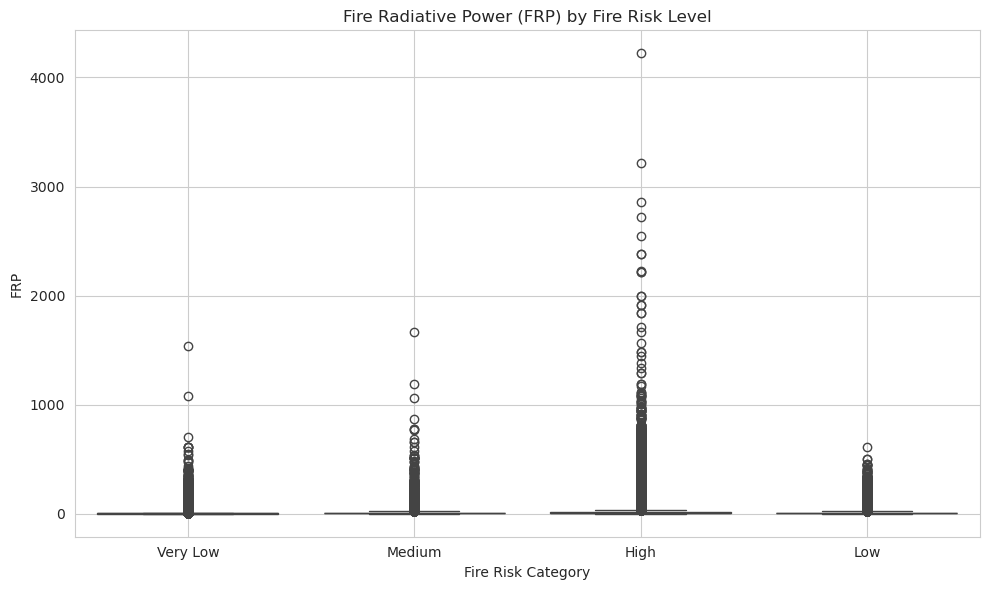

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=final_df, x="fire_risk", y="frp", palette="YlOrRd")
plt.title("Fire Radiative Power (FRP) by Fire Risk Level")
plt.ylabel("FRP")
plt.xlabel("Fire Risk Category")
plt.grid(True)
plt.tight_layout()
plt.show()


The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



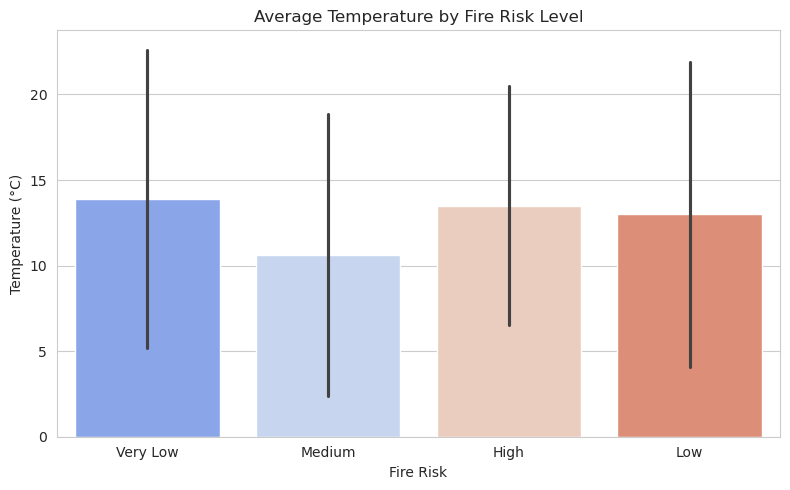

In [53]:
plt.figure(figsize=(8, 5))
sns.barplot(data=final_df, x="fire_risk", y="temp", palette="coolwarm", estimator="mean", ci="sd")
plt.title("Average Temperature by Fire Risk Level")
plt.ylabel("Temperature (°C)")
plt.xlabel("Fire Risk")
plt.tight_layout()
plt.show()


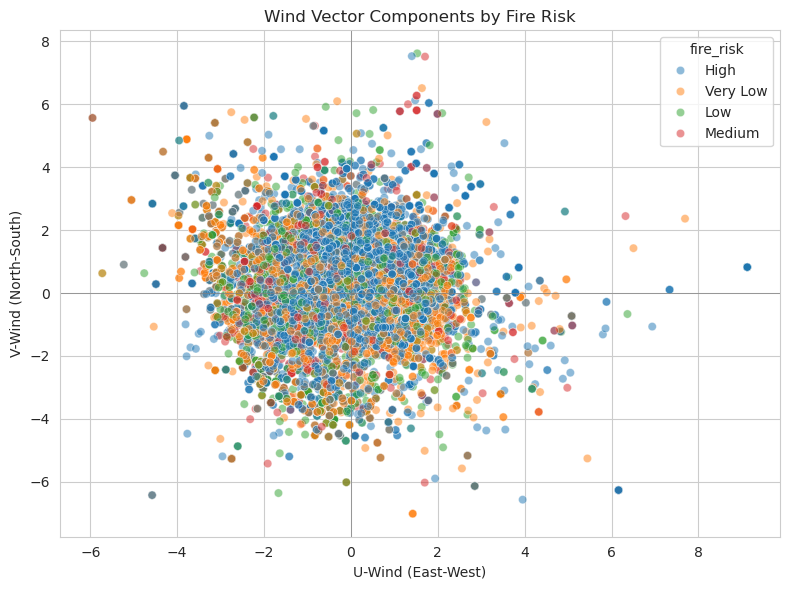

In [54]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=final_df.sample(10000), x="u_wind", y="v_wind", hue="fire_risk", alpha=0.5)
plt.axhline(0, color='gray', lw=0.5)
plt.axvline(0, color='gray', lw=0.5)
plt.title("Wind Vector Components by Fire Risk")
plt.xlabel("U-Wind (East-West)")
plt.ylabel("V-Wind (North-South)")
plt.grid(True)
plt.tight_layout()
plt.show()


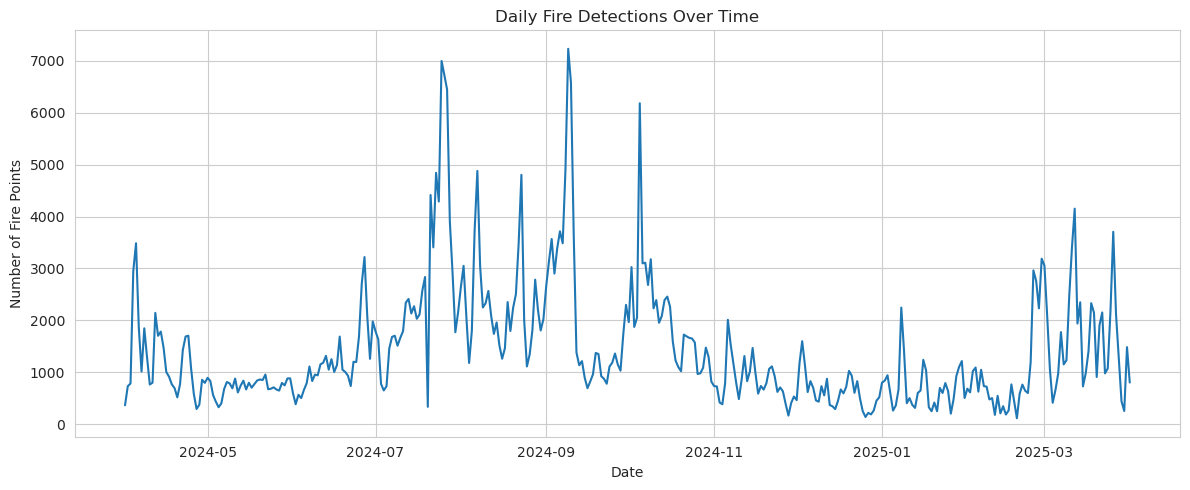

In [55]:
gdf_x['date'] = gdf_x['datetime'].dt.date
daily_counts = gdf_x.groupby('date').size()

plt.figure(figsize=(12, 5))
daily_counts.plot()
plt.title("Daily Fire Detections Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Fire Points")
plt.grid(True)
plt.tight_layout()
plt.show()


In [56]:
import pandas as pd

# Bin FRP into 20 equal-width bins
gdf_x = final_df.copy()
df = gdf_x.copy()
df['frp_bin'] = pd.cut(df['frp'], bins=20)

# Count number of datapoints in each bin
bin_counts = df['frp_bin'].value_counts().sort_index()

# Display the bin ranges and their counts
for bin_range, count in bin_counts.items():
    print(f"{bin_range}: {count} samples")

(-4.221, 211.049]: 501033 samples
(211.049, 422.098]: 2775 samples
(422.098, 633.147]: 426 samples
(633.147, 844.196]: 130 samples
(844.196, 1055.245]: 34 samples
(1055.245, 1266.294]: 15 samples
(1266.294, 1477.343]: 5 samples
(1477.343, 1688.392]: 6 samples
(1688.392, 1899.441]: 3 samples
(1899.441, 2110.49]: 4 samples
(2110.49, 2321.539]: 3 samples
(2321.539, 2532.588]: 2 samples
(2532.588, 2743.637]: 2 samples
(2743.637, 2954.686]: 1 samples
(2954.686, 3165.735]: 0 samples
(3165.735, 3376.784]: 1 samples
(3376.784, 3587.833]: 0 samples
(3587.833, 3798.882]: 0 samples
(3798.882, 4009.931]: 0 samples
(4009.931, 4220.98]: 1 samples


In [57]:
# Focus on the first bin range
first_bin_df = df[df['frp'] <= 211.049]

# Create 4 equal-width bins within this range
first_bin_df['sub_bin'] = pd.cut(first_bin_df['frp'], bins=4)

# Count number of samples in each sub-bin
sub_bin_counts = first_bin_df['sub_bin'].value_counts().sort_index()

# Display results
for bin_range, count in sub_bin_counts.items():
    print(f"{bin_range}: {count} samples")

(-0.211, 52.738]: 482812 samples
(52.738, 105.475]: 12035 samples
(105.475, 158.212]: 4163 samples
(158.212, 210.95]: 2023 samples


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [58]:
df['frp_qbin'] = pd.qcut(df['frp'], q=4, duplicates='drop')  # drop overlapping bins
print(df['frp_qbin'].value_counts().sort_index())

frp_qbin
(-0.001, 1.82]      126745
(1.82, 4.24]        125735
(4.24, 10.15]       125936
(10.15, 4220.98]    126025
Name: count, dtype: int64


In [25]:
import geohash2

# Precision 5 ≈ ~5km accuracy — good for regional modeling
final_df['geohash'] = final_df.apply(
    lambda row: geohash2.encode(row['latitude'], row['longitude'], precision=5),
    axis=1
)

from sklearn.cluster import KMeans
import numpy as np

# Choose number of clusters (e.g., 50)
coords = final_df[['latitude', 'longitude']].values
kmeans = KMeans(n_clusters=50, random_state=42).fit(coords)

# Assign cluster labels
final_df['geo_cluster'] = kmeans.labels_

In [26]:
# Mean FRP per cluster
frp_mean = final_df.groupby("geo_cluster")["frp"].mean().rename("geo_cluster_frp_mean")

# Class frequency per cluster
class_freq = final_df.groupby("geo_cluster")["frp_bin_class"].agg(lambda x: x.value_counts().idxmax()).rename("geo_cluster_mode_class")

# Merge back
final_df = final_df.merge(frp_mean, on="geo_cluster")
final_df = final_df.merge(class_freq, on="geo_cluster")

In [27]:
final_df

latitude  longitude  brightness  scan  track  bright_t31   frp  \
0       43.70303  -88.38511      297.58  0.36   0.57      272.11  0.80   
1       36.35433  -76.80997      303.37  0.40   0.37      281.62  2.00   
2       36.35509  -76.81439      295.91  0.40   0.37      280.05  0.45   
3       36.35580  -76.80739      331.55  0.40   0.37      282.06  4.80   
4       37.27381  -79.99678      310.11  0.40   0.37      273.75  1.80   
...          ...        ...         ...   ...    ...         ...   ...   
504440  46.37429 -118.74744      336.31  0.52   0.42      292.30  5.52   
504441  46.71207 -119.05591      333.69  0.51   0.41      288.78  9.07   
504442  46.71137 -119.06264      335.35  0.51   0.41      290.46  9.51   
504443  46.71198 -119.05543      330.18  0.51   0.41      288.23  8.95   
504444  46.71131 -119.06216      342.38  0.51   0.41      291.03  8.95   

       daynight            datetime fire_risk  ndvi      temp    u_wind  \
0             N 2024-04-01 07:01:00  Very Low   0.0 -4.401459  1.142914   
1             N 2024-04-01 07:03:00  Very Low   0.0  9.153229 -0.688141   
2             N 2024-04-01 07:03:00  Very Low   0.0  9.153229 -0.688141   
3             N 2024-04-01 07:03:00  Very Low   0.0  9.153229 -0.688141   
4             N 2024-04-01 07:03:00  Very Low   0.0  7.389557  0.574554   
...         ...                 ...       ...   ...       ...       ...   
504440        D 2025-04-01 21:08:00       Low   0.0 -2.300140  1.416016   
504441        D 2025-04-01 21:08:00       Low   0.0 -3.427094  2.017578   
504442        D 2025-04-01 21:08:00       Low   0.0 -3.427094  2.017578   
504443        D 2025-04-01 21:08:00       Low   0.0 -3.427094  2.017578   
504444        D 2025-04-01 21:08:00       Low   0.0 -3.427094  2.017578   

          v_wind  wind_speed  spatial_dist  month  hour  is_summer  \
0      -1.281616    1.717205     25.671441      4     7          0   
1      -0.562866    0.889020     37.190176      4     7          0   
2      -0.562866    0.889020     37.185758      4     7          0   
3      -0.562866    0.889020     37.192760      4     7          0   
4      -0.197632    0.607595     34.003228      4     7          0   
...          ...         ...           ...    ...   ...        ...   
504440  2.056824    2.497123      4.374291      4    21          0   
504441  2.871277    3.509253      4.712402      4    21          0   
504442  2.871277    3.509253      4.711786      4    21          0   
504443  2.871277    3.509253      4.712306      4    21          0   
504444  2.871277    3.509253      4.711720      4    21          0   

        frp_bin_class geohash  geo_cluster  geo_cluster_frp_mean  \
0                   0   dpc0s           22              3.893449   
1                   1   dq3qu           16              6.723629   
2                   0   dq3qu           16              6.723629   
3                   2   dq3qu           16              6.723629   
4                   0   dnxh5           24              4.051495   
...               ...     ...          ...                   ...   
504440              2   c25xc           36             17.428540   
504441              2   c273d           36             17.428540   
504442              2   c273d           36             17.428540   
504443              2   c273d           36             17.428540   
504444              2   c273d           36             17.428540   

        geo_cluster_mode_class  
0                            1  
1                            0  
2                            0  
3                            0  
4                            0  
...                        ...  
504440                       3  
504441                       3  
504442                       3  
504443                       3  
504444                       3  

[504445 rows x 24 columns]

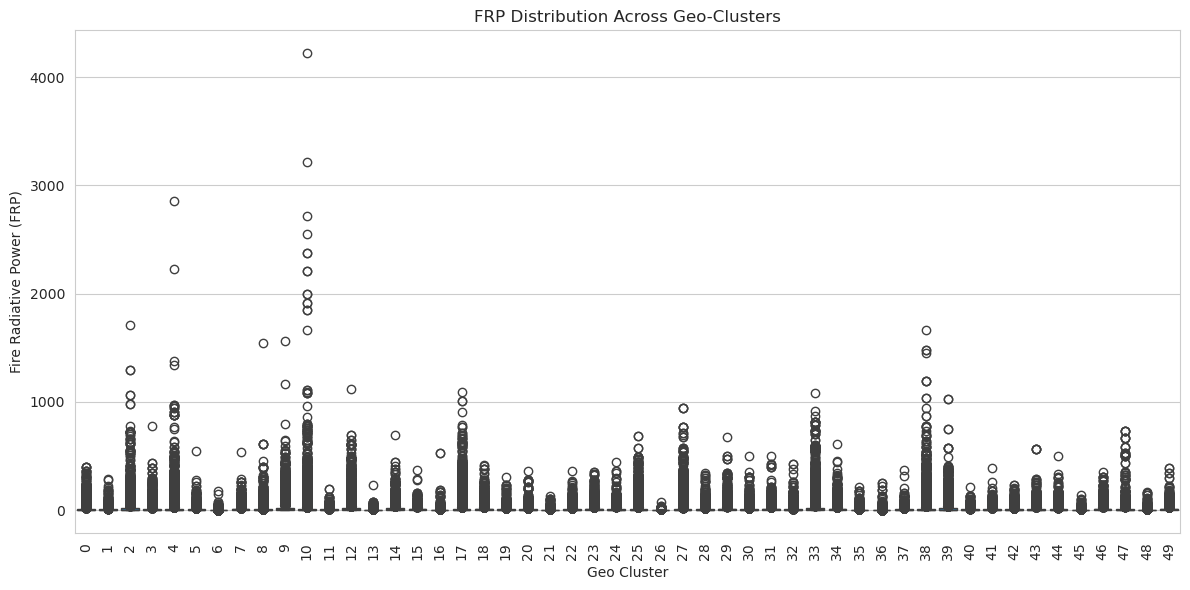

In [121]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=final_df, x='geo_cluster', y='frp')
plt.xticks(rotation=90)
plt.title("FRP Distribution Across Geo-Clusters")
plt.xlabel("Geo Cluster")
plt.ylabel("Fire Radiative Power (FRP)")
plt.tight_layout()
plt.show()


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.


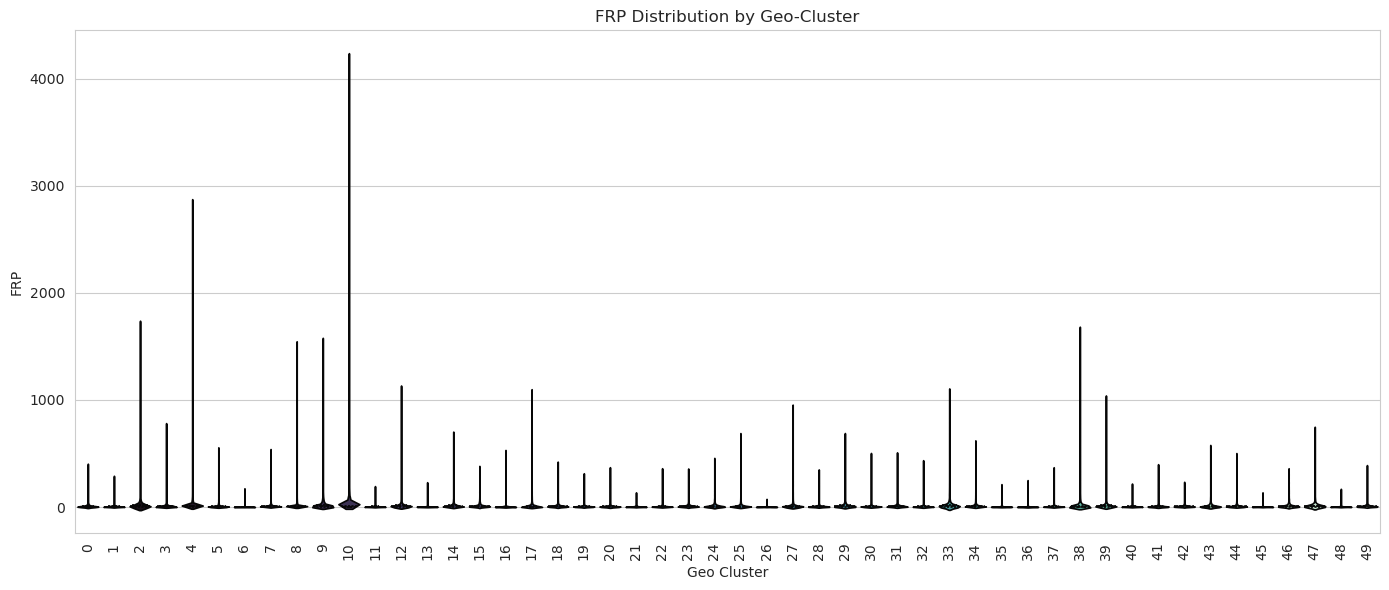

In [124]:
plt.figure(figsize=(14, 6))
sns.violinplot(data=final_df, x='geo_cluster', y='frp', inner='quartile', scale='width', palette='mako')
plt.title("FRP Distribution by Geo-Cluster")
plt.xlabel("Geo Cluster")
plt.ylabel("FRP")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

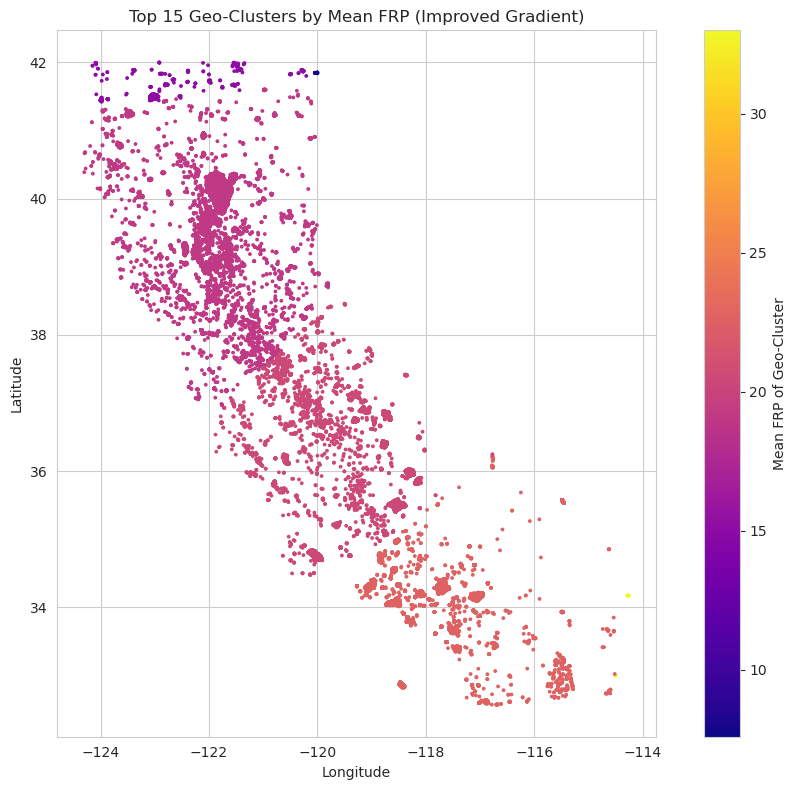

In [134]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Plot with better gradient and visibility
fig, ax = plt.subplots(figsize=(10, 8))
scatter = top_gdf.plot(
    ax=ax,
    column='cluster_frp_mean',
    cmap='plasma',                # more distinguishable than 'Reds'
    markersize=3,
    legend=True,
    legend_kwds={'label': "Mean FRP of Geo-Cluster"}
)

ax.set_title("Top 15 Geo-Clusters by Mean FRP (Improved Gradient)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()

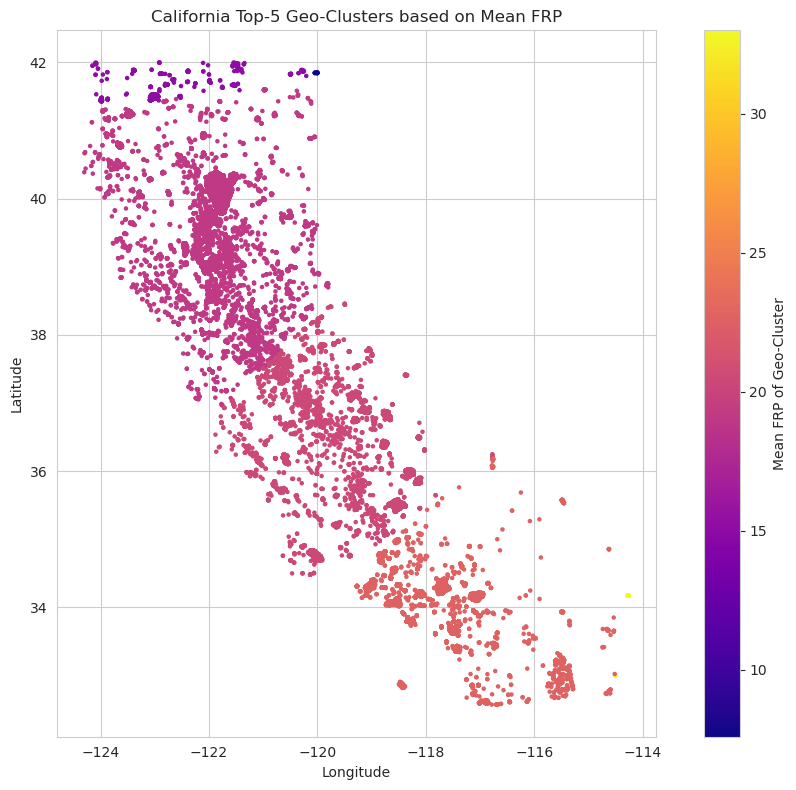

In [136]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Step 1: Define California bounding box
ca_bounds = {
    "lon_min": -124.48,
    "lon_max": -114.13,
    "lat_min": 32.53,
    "lat_max": 42.01
}

# Step 2: Filter to California
df_ca = final_df[
    (final_df['longitude'] >= ca_bounds['lon_min']) &
    (final_df['longitude'] <= ca_bounds['lon_max']) &
    (final_df['latitude'] >= ca_bounds['lat_min']) &
    (final_df['latitude'] <= ca_bounds['lat_max'])
].copy()

# Step 3: Compute top 15 geo-clusters by average FRP
cluster_means = df_ca.groupby("geo_cluster")["frp"].mean()
top_clusters = cluster_means.sort_values(ascending=False).head(15).index.tolist()

# Step 4: Filter and map cluster mean FRP to each row
top_df = df_ca[df_ca['geo_cluster'].isin(top_clusters)].copy()
top_df['cluster_frp_mean'] = top_df['geo_cluster'].map(cluster_means)

# Step 5: Convert to GeoDataFrame
top_gdf = gpd.GeoDataFrame(
    top_df,
    geometry=gpd.points_from_xy(top_df['longitude'], top_df['latitude']),
    crs="EPSG:4326"
)

# Step 6: Plot with enhanced visibility
fig, ax = plt.subplots(figsize=(10, 8))
top_gdf.plot(
    ax=ax,
    column='cluster_frp_mean',
    cmap='plasma',
    markersize=5,
    legend=True,
    legend_kwds={'label': "Mean FRP of Geo-Cluster"},
    norm=Normalize(vmin=cluster_means.min(), vmax=cluster_means.max())  # optional normalization
)

ax.set_title("California Top-5 Geo-Clusters based on Mean FRP")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()

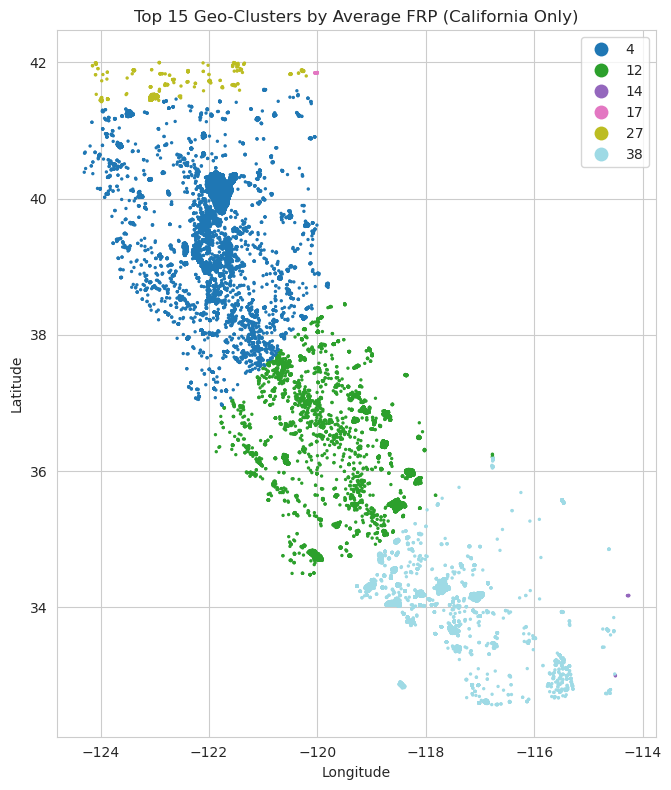

In [128]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Step 1: Define California bounding box
ca_bounds = {
    "lon_min": -124.48,
    "lon_max": -114.13,
    "lat_min": 32.53,
    "lat_max": 42.01
}

# Step 2: Filter to California
df_ca = final_df[
    (final_df['longitude'] >= ca_bounds['lon_min']) &
    (final_df['longitude'] <= ca_bounds['lon_max']) &
    (final_df['latitude'] >= ca_bounds['lat_min']) &
    (final_df['latitude'] <= ca_bounds['lat_max'])
].copy()

# Step 3: Compute top 15 geo-clusters by average FRP
top_clusters = (
    df_ca.groupby("geo_cluster")["frp"]
    .mean()
    .sort_values(ascending=False)
    .head(15)
    .index.tolist()
)

# Step 4: Filter to those clusters
top_df = df_ca[df_ca['geo_cluster'].isin(top_clusters)].copy()

# Step 5: Convert to GeoDataFrame
top_gdf = gpd.GeoDataFrame(
    top_df,
    geometry=gpd.points_from_xy(top_df['longitude'], top_df['latitude']),
    crs="EPSG:4326"
)

# Step 6: Plot
fig, ax = plt.subplots(figsize=(10, 8))
top_gdf.plot(ax=ax, column='geo_cluster', categorical=True, legend=True, cmap='tab20', markersize=2)

ax.set_title("Top 15 Geo-Clusters by Average FRP (California Only)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()

In [91]:
# Save as CSV (drops geometry)
final_df.to_parquet("gdf_x.parquet")

In [10]:
final_df = pd.read_parquet('gdf_x.parquet')

In [11]:
final_df

latitude  longitude  brightness  scan  track  bright_t31   frp  \
0       43.70303  -88.38511      297.58  0.36   0.57      272.11  0.80   
1       36.35433  -76.80997      303.37  0.40   0.37      281.62  2.00   
2       36.35509  -76.81439      295.91  0.40   0.37      280.05  0.45   
3       36.35580  -76.80739      331.55  0.40   0.37      282.06  4.80   
4       37.27381  -79.99678      310.11  0.40   0.37      273.75  1.80   
...          ...        ...         ...   ...    ...         ...   ...   
504436  46.37429 -118.74744      336.31  0.52   0.42      292.30  5.52   
504437  46.71207 -119.05591      333.69  0.51   0.41      288.78  9.07   
504438  46.71137 -119.06264      335.35  0.51   0.41      290.46  9.51   
504439  46.71198 -119.05543      330.18  0.51   0.41      288.23  8.95   
504440  46.71131 -119.06216      342.38  0.51   0.41      291.03  8.95   

       daynight fire_risk  ndvi      temp    u_wind    v_wind  wind_speed  \
0             N  Very Low   0.0 -4.401459  1.142914 -1.281616    1.717205   
1             N  Very Low   0.0  9.153229 -0.688141 -0.562866    0.889020   
2             N  Very Low   0.0  9.153229 -0.688141 -0.562866    0.889020   
3             N  Very Low   0.0  9.153229 -0.688141 -0.562866    0.889020   
4             N  Very Low   0.0  7.389557  0.574554 -0.197632    0.607595   
...         ...       ...   ...       ...       ...       ...         ...   
504436        D       Low   0.0 -2.300140  1.416016  2.056824    2.497123   
504437        D       Low   0.0 -3.427094  2.017578  2.871277    3.509253   
504438        D       Low   0.0 -3.427094  2.017578  2.871277    3.509253   
504439        D       Low   0.0 -3.427094  2.017578  2.871277    3.509253   
504440        D       Low   0.0 -3.427094  2.017578  2.871277    3.509253   

        spatial_dist  month  hour  is_summer  frp_bin_class geohash  \
0          25.671441      4     7          0              0   dpc0s   
1          37.190176      4     7          0              1   dq3qu   
2          37.185758      4     7          0              0   dq3qu   
3          37.192760      4     7          0              2   dq3qu   
4          34.003228      4     7          0              0   dnxh5   
...              ...    ...   ...        ...            ...     ...   
504436      4.374291      4    21          0              2   c25xc   
504437      4.712402      4    21          0              2   c273d   
504438      4.711786      4    21          0              2   c273d   
504439      4.712306      4    21          0              2   c273d   
504440      4.711720      4    21          0              2   c273d   

        geo_cluster  geo_cluster_frp_mean  geo_cluster_mode_class  
0                48              3.940410                       1  
1                 5              7.841778                       0  
2                 5              7.841778                       0  
3                 5              7.841778                       0  
4                 5              7.841778                       0  
...             ...                   ...                     ...  
504436           39             18.578381                       3  
504437           39             18.578381                       3  
504438           39             18.578381                       3  
504439           39             18.578381                       3  
504440           39             18.578381                       3  

[504441 rows x 23 columns]

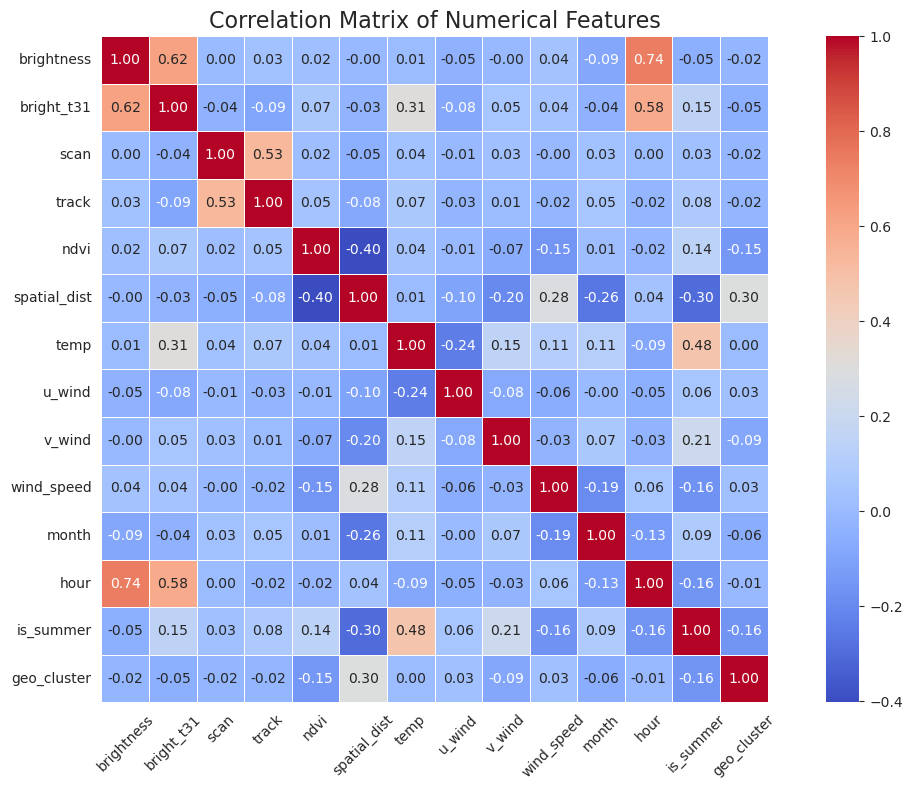

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns for correlation
numeric_cols = [
    'brightness', 'bright_t31', 'scan', 'track', 'ndvi', 'spatial_dist',
    'temp', 'u_wind', 'v_wind', 'wind_speed',
    'month', 'hour', 'is_summer', 'geo_cluster'
]

# Compute correlation matrix
corr_matrix = final_df[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, square=True)
plt.title("Correlation Matrix of Numerical Features", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

df_ml = final_df.copy()

def display_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

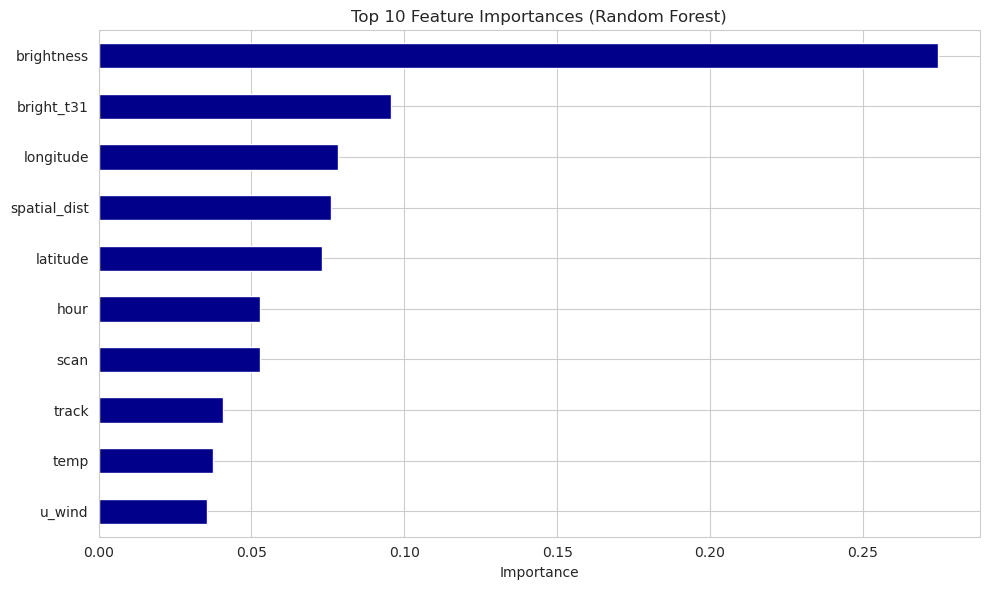

In [137]:
from sklearn.ensemble import RandomForestClassifier

# Prepare data
feature_cols = numerical_features + categorical_features
X = pd.get_dummies(final_df[feature_cols])
y = final_df['frp_bin_class'].astype(int)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

importances = pd.Series(model.feature_importances_, index=X.columns)
top_importances = importances.sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
top_importances.plot(kind='barh', color='darkblue')
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

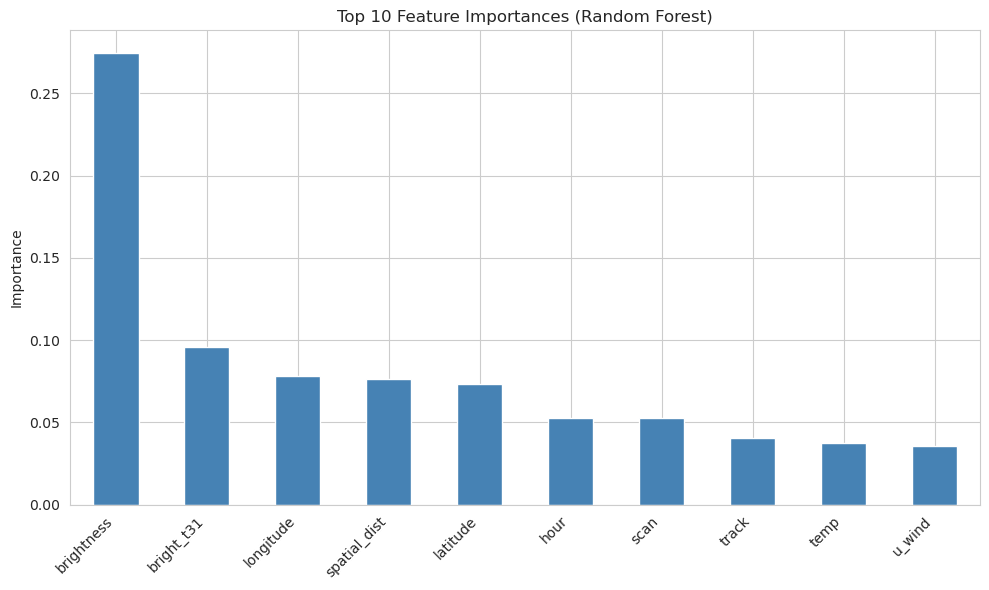

In [138]:
plt.figure(figsize=(10, 6))
top_importances.plot(kind='bar', color='steelblue')
plt.title("Top 10 Feature Importances (Random Forest)")
plt.ylabel("Importance")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

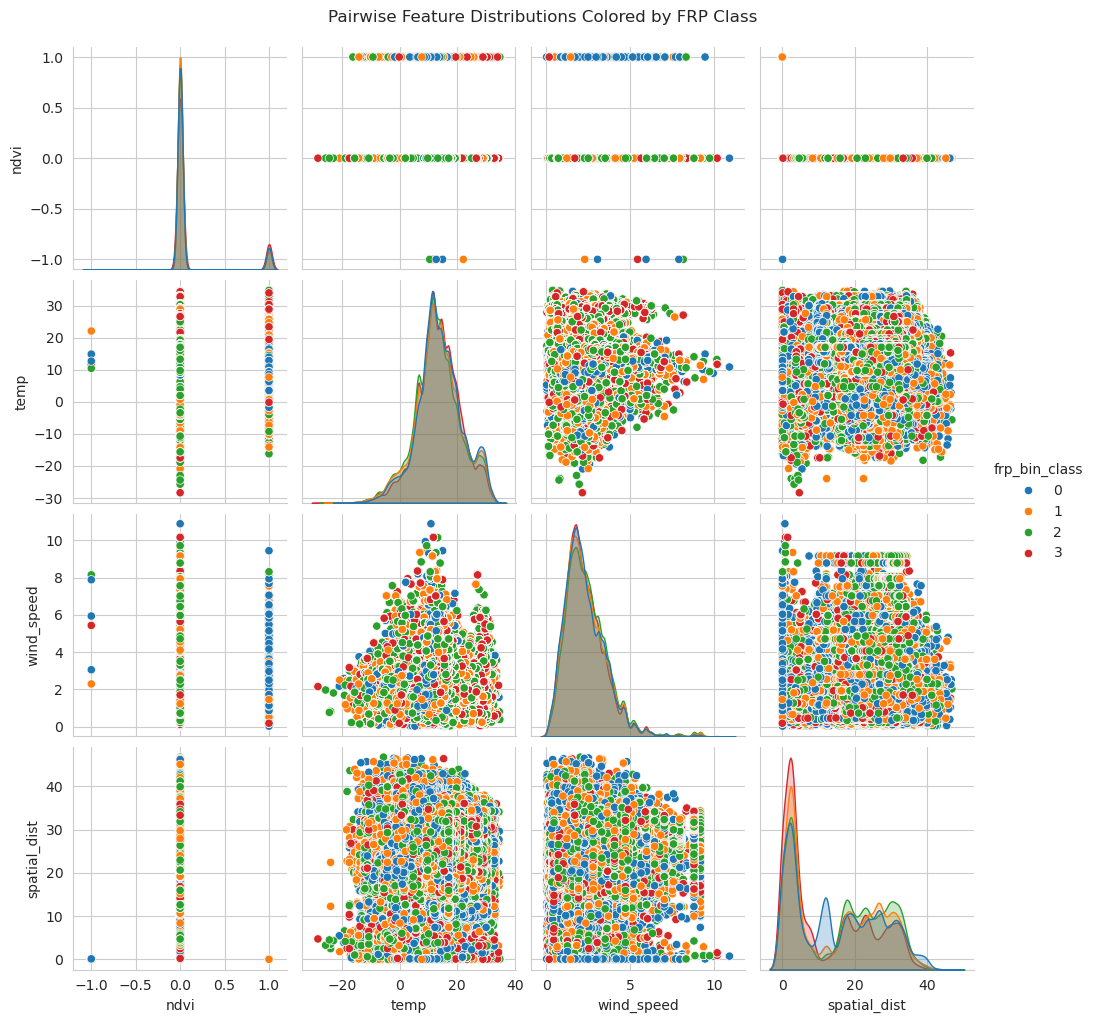

In [144]:
top_features = ['ndvi', 'temp', 'wind_speed', 'spatial_dist']
sns.pairplot(final_df[top_features + ['frp_bin_class']], hue='frp_bin_class', palette='tab10')
plt.suptitle("Pairwise Feature Distributions Colored by FRP Class", y=1.02)
plt.show()

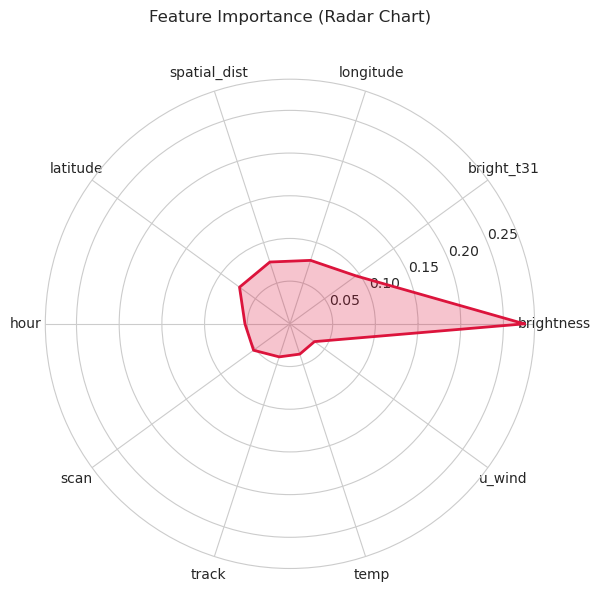

In [151]:
import numpy as np
import matplotlib.pyplot as plt

# Convert to list
features = top_importances.index.tolist()
values = top_importances.values.tolist()

# Append first element to close the radar chart loop
features.append(features[0])
values.append(values[0])

# Angles: must match length of values
angles = np.linspace(0, 2 * np.pi, len(values), endpoint=True)

# Create polar plot
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(polar=True))
ax.plot(angles, values, color='crimson', linewidth=2)
ax.fill(angles, values, color='crimson', alpha=0.25)

# Set the category labels
ax.set_xticks(angles[:-1])  # Exclude closing angle label
ax.set_xticklabels(features[:-1], fontsize=10)

# Title and layout
ax.set_title("Feature Importance (Radar Chart)", y=1.1)
plt.tight_layout()
plt.show()


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



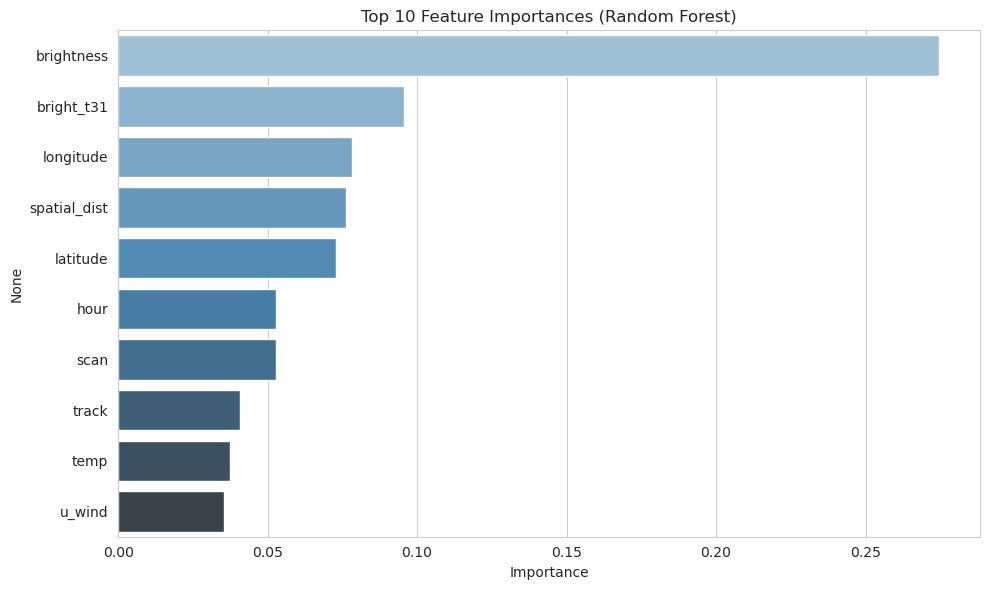

In [141]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(
    x=top_importances.values,
    y=top_importances.index,
    palette='Blues_d'
)
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

                        Accuracy  F1_score
RandomForestClassifier    0.7167    0.7167


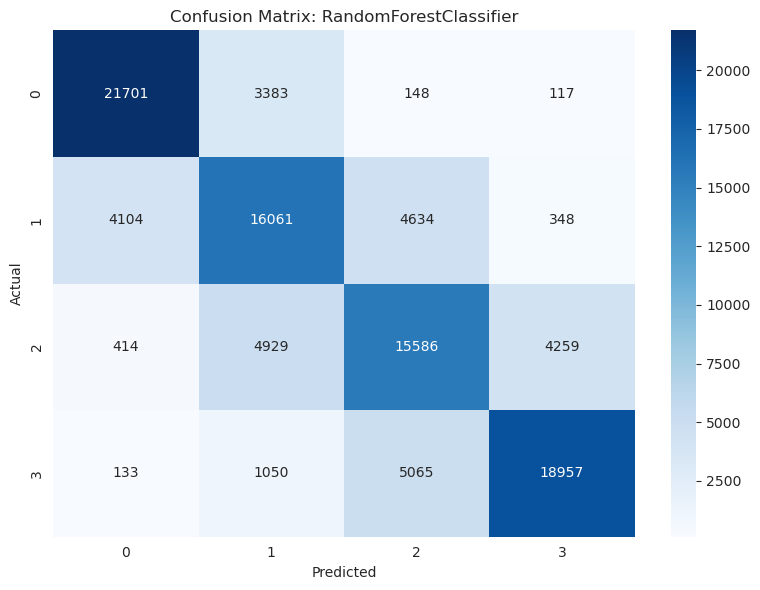

AttributeError: 'FTTransformer' object has no attribute 'feature_importances_'

In [123]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Feature lists based on your final DataFrame
numerical_features = [
    'latitude', 'longitude', 'brightness', 'scan', 'track', 'spatial_dist',
    'bright_t31', 'ndvi', 'temp', 'u_wind', 'v_wind',
    'wind_speed', 'month', 'hour', 'is_summer', 'geo_cluster'
]
categorical_features = ['daynight', 'fire_risk']
target_column = 'frp_bin_class'

# Drop rows with missing values
df_clean = final_df.dropna(subset=numerical_features + categorical_features + [target_column])

# Define feature matrix and target
X = df_clean[numerical_features + categorical_features]
y = df_clean[target_column]

# Preprocessor: One-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # keep numerical features
)

# Classification pipeline
rf_clf_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Train model
rf_clf_pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_clf_pipeline.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

# Store results
results_dict = {}
results_dict['RandomForestClassifier'] = {
    'Accuracy': round(acc, 4),
    'F1_score': round(f1, 4)
}
print(pd.DataFrame(results_dict).T)

# Confusion matrix display
def display_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

display_confusion_matrix(y_test, y_pred, "RandomForestClassifier")

Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.



                        Accuracy  F1_score
RandomForestClassifier    0.7167    0.7167
XGBoostClassifier         0.7025    0.7029


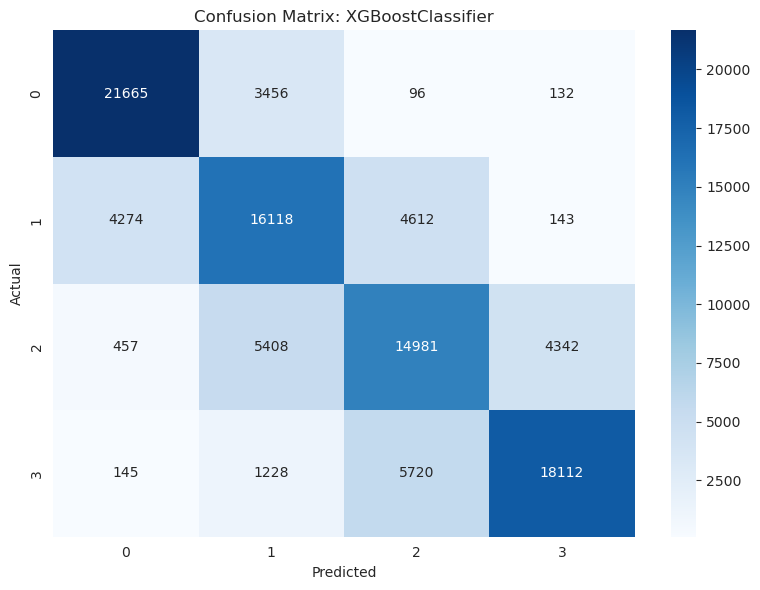

In [80]:
from xgboost import XGBClassifier

# Add spatial_dist to numerical features
numerical_features = [
    'latitude', 'longitude', 'brightness', 'scan', 'track',
    'bright_t31', 'ndvi', 'temp', 'u_wind', 'v_wind',
    'wind_speed', 'spatial_dist', 'month', 'hour', 'is_summer', 'geo_cluster'
]
categorical_features = ['daynight', 'fire_risk']
target_column = 'frp_bin_class'

# Clean and split data
df_clean = final_df.dropna(subset=numerical_features + categorical_features + [target_column])
X = df_clean[numerical_features + categorical_features]
y = df_clean[target_column]

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# XGBoost pipeline with GPU support
xgb_clf_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', XGBClassifier(
        objective='multi:softprob',
        num_class=10,
        tree_method='hist',
        device='cuda',
        eval_metric='mlogloss',
        random_state=42
    ))
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Train
xgb_clf_pipeline.fit(X_train, y_train)

# Predict & evaluate
y_pred_xgb = xgb_clf_pipeline.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')

# Log to results
results_dict['XGBoostClassifier'] = {
    'Accuracy': round(acc_xgb, 4),
    'F1_score': round(f1_xgb, 4)
}
print(pd.DataFrame(results_dict).T)

# Confusion Matrix
display_confusion_matrix(y_test, y_pred_xgb, "XGBoostClassifier")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2484
[LightGBM] [Info] Number of data points in the train set: 403552, number of used features: 22
[LightGBM] [Info] Start training from score -1.381272
[LightGBM] [Info] Start training from score -1.389272
[LightGBM] [Info] Start training from score -1.387683
[LightGBM] [Info] Start training from score -1.386969
                        Accuracy  F1_score
RandomForestClassifier    0.7167    0.7167
XGBoostClassifier         0.7025    0.7029
LightGBMClassifier        0.6966    0.6969


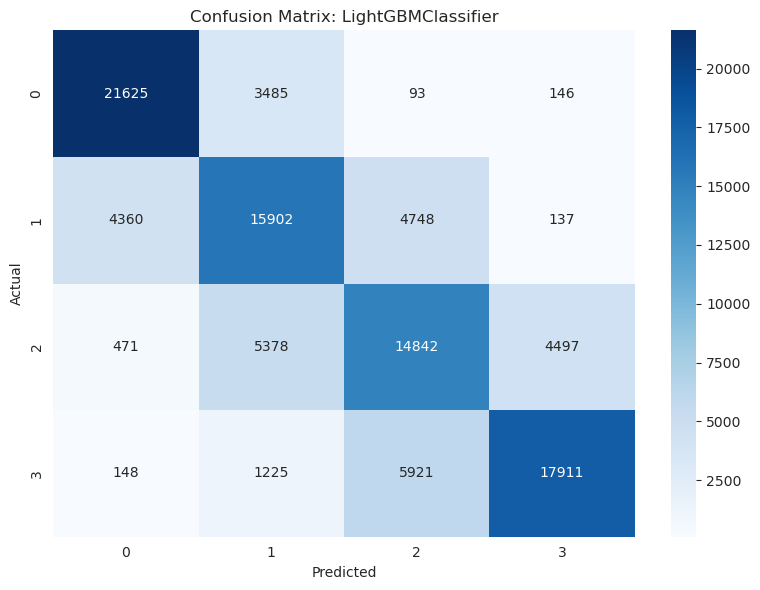

In [81]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Updated feature lists
numerical_features = [
    'latitude', 'longitude', 'brightness', 'scan', 'track', 'spatial_dist',
    'bright_t31', 'ndvi', 'temp', 'u_wind', 'v_wind',
    'wind_speed', 'month', 'hour', 'is_summer', 'geo_cluster'
]
categorical_features = ['daynight', 'fire_risk']
target_column = 'frp_bin_class'

# Clean and split data
df_clean = final_df.dropna(subset=numerical_features + categorical_features + [target_column])
X = df_clean[numerical_features + categorical_features]
y = df_clean[target_column]

# One-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# LightGBM pipeline
lgbm_clf_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', LGBMClassifier(
        objective='multiclass',
        num_class=10,
        metric='multi_logloss',
        random_state=42
        # GPU disabled due to previous compatibility issue
    ))
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Train
lgbm_clf_pipeline.fit(X_train, y_train)

# Predict & evaluate
y_pred_lgbm = lgbm_clf_pipeline.predict(X_test)
acc_lgbm = accuracy_score(y_test, y_pred_lgbm)
f1_lgbm = f1_score(y_test, y_pred_lgbm, average='weighted')

# Log results
results_dict['LightGBMClassifier'] = {
    'Accuracy': round(acc_lgbm, 4),
    'F1_score': round(f1_lgbm, 4)
}
print(pd.DataFrame(results_dict).T)

# Confusion matrix display
def display_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

display_confusion_matrix(y_test, y_pred_lgbm, "LightGBMClassifier")

In [12]:
import sys
import os
import contextlib

@contextlib.contextmanager
def suppress_stderr():
    with open(os.devnull, 'w') as fnull:
        old_stderr = sys.stderr
        sys.stderr = fnull
        try:
            yield
        finally:
            sys.stderr = old_stderr

with suppress_stderr():
    import tensorflow as tf

Epoch 1/100


2025-05-10 03:29:30.833716: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_25', 4 bytes spill stores, 4 bytes spill loads

2025-05-10 03:29:31.692778: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_27', 4 bytes spill stores, 4 bytes spill loads

2025-05-10 03:29:34.055591: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34', 4 bytes spill stores, 4 bytes spill loads

2025-05-10 03:30:18.600610: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_27', 32 bytes spill stores, 32 bytes spill loads

2025-05-10 03:30:19.082748: I external/local_xla/xla/s

198/198 - 65s - 331ms/step - accuracy: 0.4659 - loss: 1.1507 - val_accuracy: 0.5085 - val_loss: 1.0565
Epoch 2/100
198/198 - 11s - 57ms/step - accuracy: 0.5103 - loss: 1.0509 - val_accuracy: 0.5015 - val_loss: 1.0444
Epoch 3/100
198/198 - 11s - 58ms/step - accuracy: 0.5223 - loss: 1.0331 - val_accuracy: 0.4997 - val_loss: 1.0850
Epoch 4/100
198/198 - 11s - 58ms/step - accuracy: 0.5273 - loss: 1.0234 - val_accuracy: 0.5303 - val_loss: 1.0155
Epoch 5/100
198/198 - 12s - 58ms/step - accuracy: 0.5339 - loss: 1.0102 - val_accuracy: 0.5388 - val_loss: 0.9972
Epoch 6/100
198/198 - 12s - 59ms/step - accuracy: 0.5390 - loss: 1.0012 - val_accuracy: 0.5373 - val_loss: 1.0060
Epoch 7/100
198/198 - 11s - 58ms/step - accuracy: 0.5405 - loss: 0.9971 - val_accuracy: 0.5419 - val_loss: 0.9915
Epoch 8/100
198/198 - 12s - 58ms/step - accuracy: 0.5441 - loss: 0.9927 - val_accuracy: 0.5485 - val_loss: 0.9819
Epoch 9/100
198/198 - 11s - 58ms/step - accuracy: 0.5435 - loss: 0.9908 - val_accuracy: 0.5468 - va

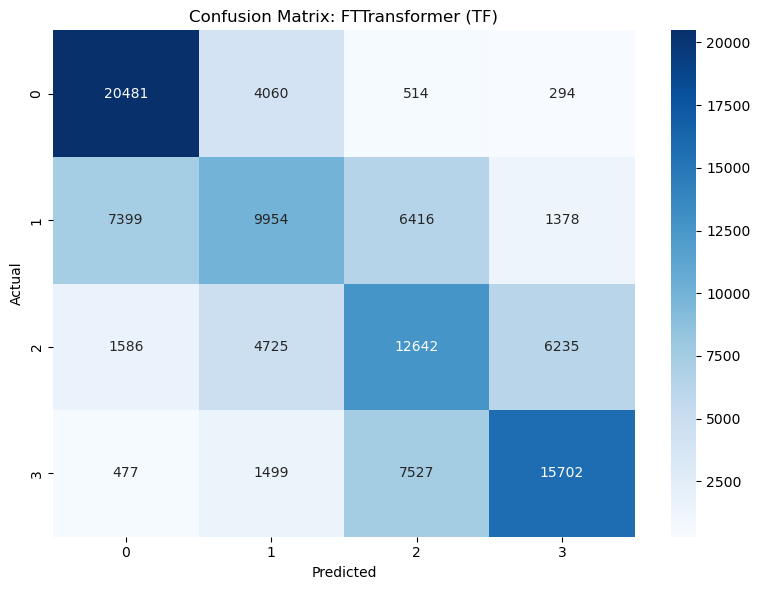

In [14]:
# -------------------- Imports --------------------
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, callbacks
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# -------------------- Config --------------------
numerical_features = [
    'latitude', 'longitude', 'brightness', 'scan', 'track',
    'bright_t31', 'ndvi', 'temp', 'u_wind', 'v_wind',
    'wind_speed', 'spatial_dist', 'month', 'hour', 'is_summer', 'geo_cluster'
]
categorical_features = ['daynight', 'fire_risk']
target_column = 'frp_bin_class'

# -------------------- Preprocessing --------------------
df_clean = final_df.dropna(subset=numerical_features + categorical_features + [target_column]).copy()

label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col])
    label_encoders[col] = le

scaler = StandardScaler()
df_clean[numerical_features] = scaler.fit_transform(df_clean[numerical_features])

X = df_clean[numerical_features + categorical_features]
y = df_clean[target_column].astype(int)
num_classes = y.nunique()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

X_train_np = X_train.values.astype(np.float32)
X_test_np = X_test.values.astype(np.float32)
y_train_np = y_train.values.astype(np.int32)
y_test_np = y_test.values.astype(np.int32)

# Compute class weights
class_weights_array = compute_class_weight(class_weight="balanced", classes=np.unique(y_train_np), y=y_train_np)
class_weights = dict(enumerate(class_weights_array))

# -------------------- Transformer Block --------------------
class TransformerEncoderBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, ff_dim, dropout_rate=0.1):
        super().__init__()
        self.attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = models.Sequential([
            layers.Dense(ff_dim, activation='gelu'),
            layers.Dense(d_model)
        ])
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, x, training=False):
        attn_output = self.attn(x, x)
        x = self.norm1(x + self.dropout1(attn_output, training=training))
        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout2(ffn_output, training=training))
        return x

# -------------------- FT-Transformer --------------------
class FTTransformer(tf.keras.Model):
    def __init__(self, num_numerical, num_categorical, cat_cardinalities, num_classes, d_token=32, n_heads=4, n_layers=3):
        super().__init__()
        self.num_numerical = num_numerical
        self.num_categorical = num_categorical
        self.d_token = d_token

        self.num_dense = layers.Dense(d_token)

        self.cat_embeddings = [
            layers.Embedding(input_dim=card + 1, output_dim=d_token)
            for card in cat_cardinalities
        ]

        self.token_normalization = layers.LayerNormalization(epsilon=1e-6)
        self.cls_token = self.add_weight(name="cls_token", shape=(1, 1, d_token), initializer="random_normal")

        self.transformer_blocks = [
            TransformerEncoderBlock(d_model=d_token, num_heads=n_heads, ff_dim=4 * d_token)
            for _ in range(n_layers)
        ]

        self.head = models.Sequential([
            layers.Dense(128, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.Dense(64, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.2),
            layers.Dense(num_classes)
        ])

    def call(self, x, training=False):
        num_feats = x[:, :self.num_numerical]
        cat_feats = x[:, self.num_numerical:]

        num_tokens = tf.expand_dims(num_feats, -1)
        num_tokens = self.num_dense(num_tokens)

        cat_tokens = tf.stack([
            emb(tf.clip_by_value(tf.cast(cat_feats[:, i], tf.int32), 0, emb.input_dim - 1))
            for i, emb in enumerate(self.cat_embeddings)
        ], axis=1)

        tokens = tf.concat([num_tokens, cat_tokens], axis=1)
        tokens = self.token_normalization(tokens)

        cls_tokens = tf.tile(self.cls_token, [tf.shape(x)[0], 1, 1])
        tokens = tf.concat([cls_tokens, tokens], axis=1)

        for block in self.transformer_blocks:
            tokens = block(tokens, training=training)

        cls_output = tokens[:, 0]
        return self.head(cls_output)

# -------------------- Model Init --------------------
cat_cardinalities = [df_clean[col].nunique() for col in categorical_features]

lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-3,
    decay_steps=(len(X_train_np) // 512) * 20,
    alpha=1e-5
)

optimizer = tf.keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=1e-4)

model = FTTransformer(
    num_numerical=len(numerical_features),
    num_categorical=len(categorical_features),
    cat_cardinalities=cat_cardinalities,
    num_classes=num_classes
)

model.compile(
    optimizer=optimizer,
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# -------------------- Training --------------------
early_stop = callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(
    X_train_np, y_train_np,
    validation_data=(X_test_np, y_test_np),
    batch_size=2048,
    epochs=100,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=2
)

# -------------------- Evaluation --------------------
y_pred_logits = model.predict(X_test_np)
y_pred_labels = np.argmax(y_pred_logits, axis=1)

acc = accuracy_score(y_test_np, y_pred_labels)
f1 = f1_score(y_test_np, y_pred_labels, average='weighted')

results_dict = {
    'FTTransformer': {
        'Accuracy': round(acc, 4),
        'F1_score': round(f1, 4)
    }
}

print("\n🔍 Model Performance Comparison:")
print(pd.DataFrame(results_dict).T)

# -------------------- Confusion Matrix --------------------
def display_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

display_confusion_matrix(y_test_np, y_pred_labels, "FTTransformer (TF)")

In [32]:
# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 349.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 446.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [torchaudio]2 [torchaudio]
Note: you may need to restart the kernel to use updated packages.


In [37]:
import torch
print("Is CUDA available?", torch.cuda.is_available())
torch.cuda.init()
print(f"CUDA initialized: {torch.cuda.is_initialized()}")

Is CUDA available? True
CUDA initialized: True


In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------- Configuration --------------------
sequence_length = 7
geo_col = 'geo_cluster'
time_col = 'datetime'
target_column = 'frp_bin_class'

numerical_features = [
    'latitude', 'longitude', 'brightness', 'scan', 'track',
    'bright_t31', 'ndvi', 'temp', 'u_wind', 'v_wind',
    'wind_speed', 'spatial_dist', 'month', 'hour', 'is_summer'
]

# -------------------- Sequence Preparation --------------------
df_seq = final_df.copy().dropna(subset=numerical_features + [target_column])
df_seq = df_seq.sort_values([geo_col, time_col])

scaler = StandardScaler()
df_seq[numerical_features] = scaler.fit_transform(df_seq[numerical_features])

sequences = []
labels = []

for _, group in df_seq.groupby(geo_col):
    group = group.sort_values(time_col)
    for i in range(len(group) - sequence_length):
        seq = group.iloc[i:i + sequence_length][numerical_features].values
        label = group.iloc[i + sequence_length][target_column]
        sequences.append(seq)
        labels.append(label)

X_seq = np.array(sequences)
y_seq = np.array(labels)

# -------------------- Train/Val/Test Split --------------------
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, stratify=y_seq, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, stratify=y_train, random_state=42)

# -------------------- Build LSTM Model --------------------
num_classes = len(np.unique(y_seq))

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2])),

    tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# -------------------- Train --------------------
early_stop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=2
)

# -------------------- Evaluate --------------------
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\n✅ LSTM Accuracy (TF): {acc:.4f}")
print(f"✅ LSTM F1 Score (TF): {f1:.4f}")

# -------------------- Confusion Matrix --------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix: LSTM Classifier (TF)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

KeyError: 'datetime'

0:	learn: 0.6426108	total: 150ms	remaining: 12m 32s
100:	learn: 0.6858596	total: 10.4s	remaining: 8m 24s
200:	learn: 0.6944007	total: 21s	remaining: 8m 21s
300:	learn: 0.6994604	total: 31.7s	remaining: 8m 15s
400:	learn: 0.7034879	total: 42.1s	remaining: 8m 2s
500:	learn: 0.7072195	total: 52.4s	remaining: 7m 50s
600:	learn: 0.7105579	total: 1m 2s	remaining: 7m 37s
700:	learn: 0.7133432	total: 1m 12s	remaining: 7m 23s
800:	learn: 0.7159834	total: 1m 22s	remaining: 7m 10s
900:	learn: 0.7184282	total: 1m 32s	remaining: 6m 59s
1000:	learn: 0.7208265	total: 1m 41s	remaining: 6m 47s
1100:	learn: 0.7231334	total: 1m 51s	remaining: 6m 36s
1200:	learn: 0.7252968	total: 2m 1s	remaining: 6m 25s
1300:	learn: 0.7274232	total: 2m 12s	remaining: 6m 15s
1400:	learn: 0.7295870	total: 2m 22s	remaining: 6m 6s
1500:	learn: 0.7315758	total: 2m 32s	remaining: 5m 56s
1600:	learn: 0.7335108	total: 2m 42s	remaining: 5m 45s
1700:	learn: 0.7353599	total: 2m 53s	remaining: 5m 35s
1800:	learn: 0.7373444	total: 3m 

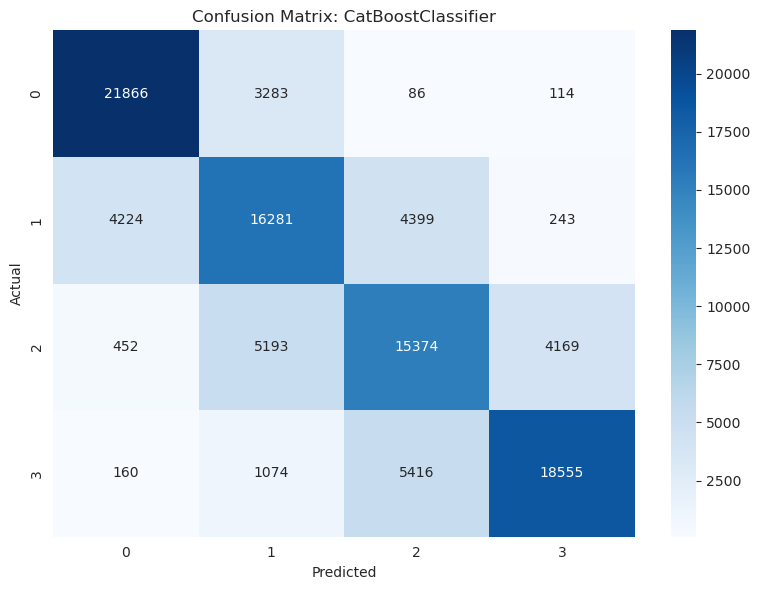

In [87]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# -------------------- Config --------------------
numerical_features = [
    'latitude', 'longitude', 'brightness', 'scan', 'track',
    'bright_t31', 'ndvi', 'temp', 'u_wind', 'v_wind',
    'wind_speed', 'spatial_dist', 'month', 'hour', 'is_summer', 'geo_cluster'
]
categorical_features = ['daynight', 'fire_risk']
target_column = 'frp_bin_class'

# -------------------- Preprocessing --------------------
df_clean = final_df.dropna(subset=numerical_features + categorical_features + [target_column])
X = df_clean[numerical_features + categorical_features]
y = df_clean[target_column].astype(int)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# One-hot encode non-CatBoost-friendly categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# CatBoost Pipeline (no GPU due to installation issues noted earlier)
catboost_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', CatBoostClassifier(
        iterations=5000,
        learning_rate=0.05,
        depth=8,
        loss_function='MultiClass',
        eval_metric='TotalF1',
        verbose=100,
        random_seed=42,
        task_type='CPU'  # GPU optional if available
    ))
])

# -------------------- Train --------------------
catboost_pipeline.fit(X_train, y_train)

# -------------------- Predict & Evaluate --------------------
y_pred_cat = catboost_pipeline.predict(X_test)
acc_cat = accuracy_score(y_test, y_pred_cat)
f1_cat = f1_score(y_test, y_pred_cat, average='weighted')

results_dict['CatBoostClassifier'] = {
    'Accuracy': round(acc_cat, 4),
    'F1_score': round(f1_cat, 4)
}
print(pd.DataFrame(results_dict).T)

# -------------------- Confusion Matrix --------------------
def display_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

display_confusion_matrix(y_test, y_pred_cat, "CatBoostClassifier")

In [9]:
# pip install keras-nlp

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.1/792.1 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.7/792.7 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [keras-nlp]/5 [keras-hub]-text]
Note: you may need to restart the kernel to use updated packages.


In [8]:
# ------------------ Torch Setup ------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

# -------------------- Config --------------------
numerical_features = [
    'latitude', 'longitude', 'brightness', 'scan', 'track',
    'bright_t31', 'ndvi', 'temp', 'u_wind', 'v_wind',
    'wind_speed', 'spatial_dist', 'month', 'hour', 'is_summer', 'geo_cluster'
]
categorical_features = ['daynight', 'fire_risk']
target_column = 'frp_bin_class'

# -------------------- Preprocessing --------------------
df_clean = final_df.dropna(subset=numerical_features + categorical_features + [target_column])
X = df_clean[numerical_features + categorical_features]
y = df_clean[target_column].astype(int)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# -------------------- Config --------------------
numerical_features = [
    'latitude', 'longitude', 'brightness', 'scan', 'track',
    'bright_t31', 'ndvi', 'temp', 'u_wind', 'v_wind',
    'wind_speed', 'spatial_dist', 'month', 'hour', 'is_summer', 'geo_cluster'
]
categorical_features = ['daynight', 'fire_risk']
target_column = 'frp_bin_class'

# ------------------ FT-Transformer Model ------------------
class FTTransformer(nn.Module):
    def __init__(self, num_numerical, num_categorical, num_classes, cat_cardinalities, d_token=32, n_heads=4, n_layers=3):
        super().__init__()
        self.num_numerical = num_numerical
        self.num_categorical = num_categorical
        self.d_token = d_token

        self.num_linear = nn.Linear(1, d_token)

        self.cat_embeddings = nn.ModuleList([
            nn.Embedding(card + 1, d_token) for card in cat_cardinalities
        ])

        self.cls_token = nn.Parameter(torch.randn(1, 1, d_token))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_token,
            nhead=n_heads,
            dim_feedforward=4 * d_token,
            batch_first=True,
            dropout=0.1,
            activation='gelu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.head = nn.Sequential(
            nn.Linear(d_token, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        B = x.shape[0]
        num_feats = x[:, :self.num_numerical].unsqueeze(-1)
        cat_feats = x[:, self.num_numerical:].long()

        for i in range(self.num_categorical):
            cat_feats[:, i] = torch.clamp(cat_feats[:, i], max=self.cat_embeddings[i].num_embeddings - 1)

        num_tokens = self.num_linear(num_feats)
        cat_tokens = torch.stack([emb(cat_feats[:, i]) for i, emb in enumerate(self.cat_embeddings)], dim=1)

        tokens = torch.cat([num_tokens, cat_tokens], dim=1)
        cls = self.cls_token.expand(B, -1, -1)
        tokens = torch.cat([cls, tokens], dim=1)

        x_encoded = self.transformer(tokens)
        cls_out = x_encoded[:, 0]
        return self.head(cls_out)

# ------------------ FT-Transformer Pipeline ------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Clean and split
df_clean = final_df.dropna(subset=numerical_features + categorical_features + [target_column]).copy()
X = df_clean[numerical_features + categorical_features]
y = df_clean[target_column].astype(int)
num_classes = y.nunique()

# Encode categorical
from sklearn.preprocessing import LabelEncoder, StandardScaler
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col])
    label_encoders[col] = le

# Standardize numerical
scaler = StandardScaler()
df_clean[numerical_features] = scaler.fit_transform(df_clean[numerical_features])

# Final split
X = df_clean[numerical_features + categorical_features]
y = df_clean[target_column].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Torch Tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

# Model Init
cat_cardinalities = [df_clean[col].nunique() for col in categorical_features]
model = FTTransformer(
    num_numerical=len(numerical_features),
    num_categorical=len(categorical_features),
    num_classes=num_classes,
    cat_cardinalities=cat_cardinalities
).to(device)

# Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# ------------------ Training Loop ------------------
best_val_loss = float('inf')
patience = 10
epochs_no_improve = 0
best_model_state = None
epochs = 100

for epoch in range(epochs):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False, ncols=100)

    for xb, yb in loop:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        loop.set_postfix(loss=loss.item())
        total_loss += loss.item()

    scheduler.step()

    model.eval()
    with torch.no_grad():
        val_preds = model(X_test_tensor)
        val_loss = criterion(val_preds, y_test_tensor).item()

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}: Train Loss = {total_loss:.4f}, Val Loss = {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"⏹️ Early stopping at epoch {epoch+1}")
            break

if best_model_state:
    model.load_state_dict(best_model_state)

# ------------------ Evaluation ------------------
model.eval()
with torch.no_grad():
    y_pred_logits = model(X_test_tensor)
    y_pred_labels = torch.argmax(y_pred_logits, dim=1)

acc_ft = accuracy_score(y_test_tensor.cpu(), y_pred_labels.cpu())
f1_ft = f1_score(y_test_tensor.cpu(), y_pred_labels.cpu(), average='weighted')

results_dict['FTTransformer'] = {
    'Accuracy': round(acc_ft, 4),
    'F1_score': round(f1_ft, 4)
}

# Display Results
print("\n🔍 Model Performance Comparison:")
print(pd.DataFrame(results_dict).T)

# ------------------ Confusion Matrix ------------------
def display_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

display_confusion_matrix(y_test_tensor.cpu().numpy(), y_pred_labels.cpu().numpy(), "FTTransformer")

RuntimeError: CUDA error: invalid configuration argument
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


----------------------------------------------------------------------------------------------------------------------------

In [18]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from catboost import CatBoostClassifier
from skorch import NeuralNetClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------ Config ------------------

numerical_features = [
    'latitude', 'longitude', 'brightness', 'scan', 'track', 'spatial_dist',
    'bright_t31', 'ndvi', 'temp', 'u_wind', 'v_wind',
    'wind_speed', 'month', 'hour', 'is_summer',
    'geo_cluster_frp_mean', 'geo_cluster'
]
categorical_features = ['daynight', 'fire_risk', 'geo_cluster_mode_class']
target_column = 'frp_bin_class'

# ------------------ Preprocessing ------------------

df_clean = final_df.dropna(subset=numerical_features + categorical_features + [target_column])
X = df_clean[numerical_features + categorical_features]
y = df_clean[target_column].astype(int)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Preprocessor
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
], remainder='passthrough')

# ------------------ MLP Module ------------------

class MLPModule(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, output_dim)
        )

    def forward(self, X):
        return self.model(X)

# ------------------ MLP Wrapper ------------------

X_train_proc = preprocessor.fit_transform(X_train)
mlp_net = NeuralNetClassifier(
    MLPModule,
    module__input_dim=X_train_proc.shape[1],
    module__output_dim=y.nunique(),
    max_epochs=20,
    lr=1e-3,
    optimizer=torch.optim.AdamW,
    batch_size=512,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    verbose=0
)

# ------------------ Individual Models ------------------

rf_model = Pipeline([
    ('preprocess', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

cat_model = Pipeline([
    ('preprocess', preprocessor),
    ('clf', CatBoostClassifier(
        iterations=300,
        learning_rate=0.05,
        depth=6,
        loss_function='MultiClass',
        task_type='GPU',  # ✅ GPU Enabled
        devices='0',
        verbose=0,
        random_state=42
    ))
])

mlp_model = Pipeline([
    ('preprocess', preprocessor),
    ('clf', mlp_net)
])

# ------------------ Voting Ensemble ------------------

ensemble = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('cat', cat_model),
        ('mlp', mlp_model)
    ],
    voting='soft'
)

# ------------------ Train with Progress ------------------

print("🚀 Training Voting Ensemble (RF + CatBoost + MLP)...")
with tqdm(total=1, desc="Fitting Ensemble", ncols=600) as pbar:
    ensemble.fit(X_train, y_train)
    pbar.update(1)
print("✅ Ensemble training complete.")

# ------------------ Evaluate ------------------

y_pred = ensemble.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

# Append to results_dict
results_dict['VotingEnsemble_RF_CatBoost_MLP'] = {
    'Accuracy': round(acc, 4),
    'F1_score': round(f1, 4)
}

# Show results
print("\n🔍 Model Performance Comparison:")
print(pd.DataFrame(results_dict).T)
# ------------------ Imports ------------------
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from catboost import CatBoostClassifier
from skorch import NeuralNetClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ------------------ Config ------------------

numerical_features = [
    'latitude', 'longitude', 'brightness', 'scan', 'track', 'spatial_dist',
    'bright_t31', 'ndvi', 'temp', 'u_wind', 'v_wind',
    'wind_speed', 'month', 'hour', 'is_summer',
    'geo_cluster_frp_mean', 'geo_cluster'
]
categorical_features = ['daynight', 'fire_risk', 'geo_cluster_mode_class']
target_column = 'frp_bin_class'

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ------------------ Preprocessing ------------------

df_clean = final_df.dropna(subset=numerical_features + categorical_features + [target_column])
X = df_clean[numerical_features + categorical_features]
y = df_clean[target_column].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Preprocessor (OneHotEncoder for categorical, passthrough for numerical)
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
], remainder='passthrough')

# ------------------ MLP Module ------------------

class MLPModule(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, output_dim)
        )

    def forward(self, X):
        return self.model(X)

# ------------------ Skorch MLP ------------------

# Fit preprocessor to get input dimension
X_train_proc = preprocessor.fit_transform(X_train).astype(np.float32)

mlp_net = NeuralNetClassifier(
    MLPModule,
    module__input_dim=X_train_proc.shape[1],
    module__output_dim=y.nunique(),
    max_epochs=20,
    lr=1e-3,
    optimizer=torch.optim.AdamW,
    batch_size=512,
    device=device,
    verbose=0,
    iterator_train__dtype=torch.float32,
    iterator_valid__dtype=torch.float32
)

# ------------------ Model Pipelines ------------------

# Random Forest
rf_model = Pipeline([
    ('preprocess', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

# CatBoost (GPU)
cat_model = Pipeline([
    ('preprocess', preprocessor),
    ('clf', CatBoostClassifier(
        iterations=300,
        learning_rate=0.05,
        depth=6,
        loss_function='MultiClass',
        task_type='GPU',
        devices='0',
        verbose=0,
        random_state=42
    ))
])

# MLP (with float32 conversion)
mlp_model = Pipeline([
    ('preprocess', preprocessor),
    ('astype_float32', FunctionTransformer(lambda X: X.astype(np.float32))),
    ('clf', mlp_net)
])

# ------------------ Voting Ensemble ------------------

ensemble = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('cat', cat_model),
        ('mlp', mlp_model)
    ],
    voting='soft'
)

# ------------------ Training ------------------

print("🚀 Training Voting Ensemble (RF + CatBoost + MLP)...")
with tqdm(total=1, desc="Fitting Ensemble", ncols=600) as pbar:
    ensemble.fit(X_train, y_train)
    pbar.update(1)
print("✅ Ensemble training complete.")

# ------------------ Evaluation ------------------

y_pred = ensemble.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

results_dict = {}
results_dict['VotingEnsemble_RF_CatBoost_MLP'] = {
    'Accuracy': round(acc, 4),
    'F1_score': round(f1, 4)
}

# ------------------ Results ------------------

print("\n🔍 Model Performance Comparison:")
print(pd.DataFrame(results_dict).T)

# ------------------ Confusion Matrix ------------------

def display_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

display_confusion_matrix(y_test, y_pred, "VotingEnsemble (RF + CatBoost + MLP)")
# ------------------ Confusion Matrix ------------------

def display_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

display_confusion_matrix(y_test, y_pred, "VotingEnsemble (RF + CatBoost + MLP)")

🚀 Training Voting Ensemble (RF + CatBoost + MLP)...


Fitting Ensemble:   0%|                                                                                       …

RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float

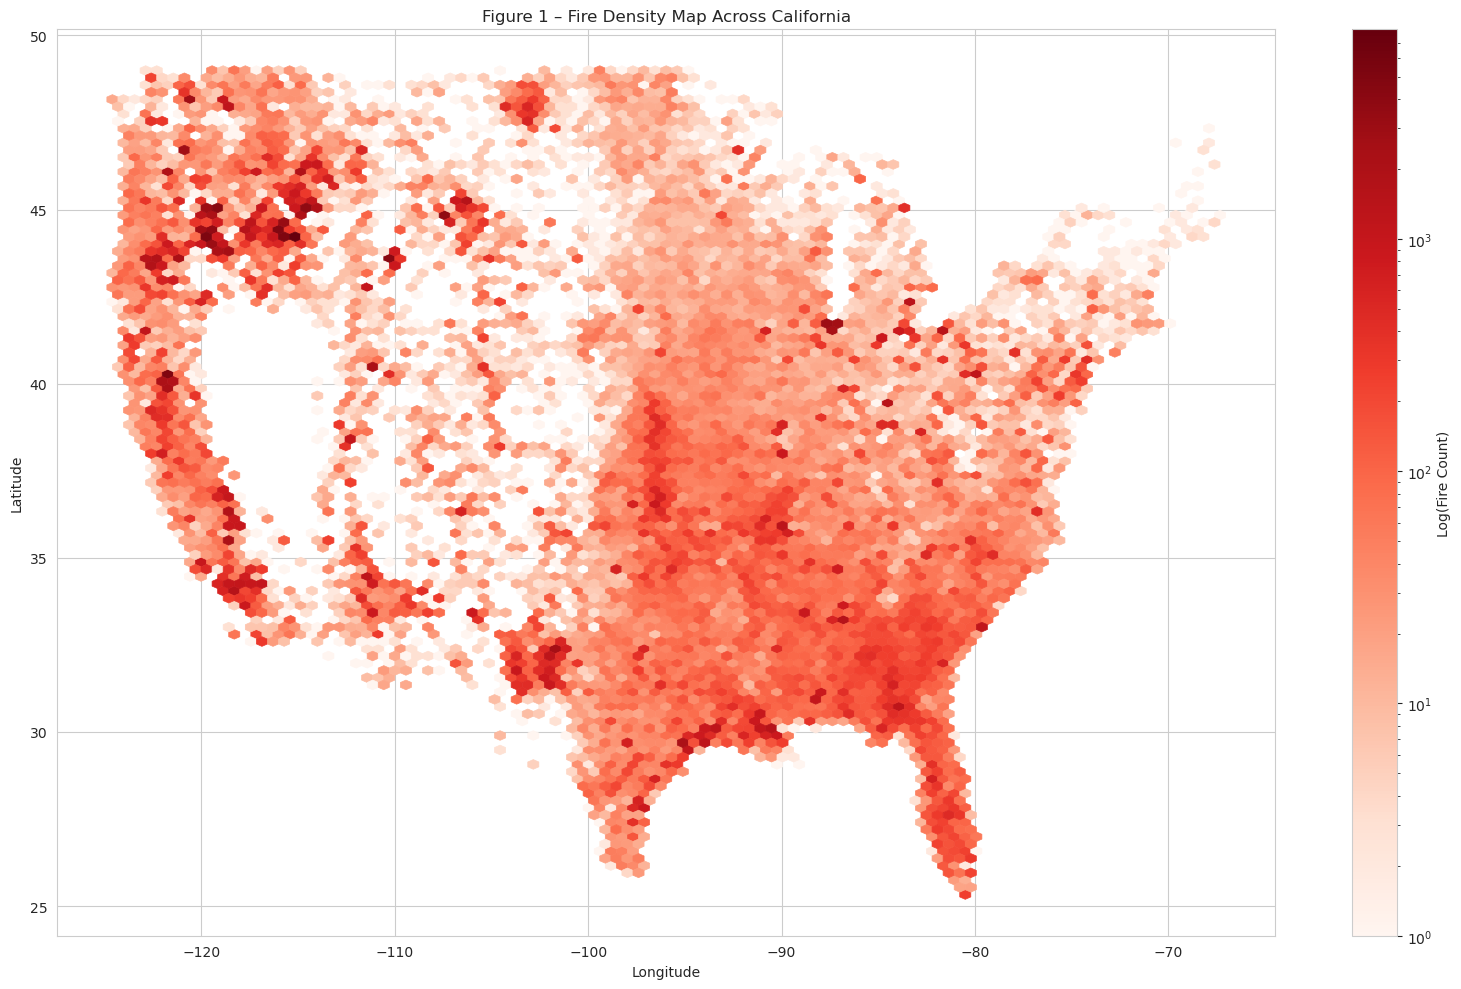

In [98]:
import matplotlib.pyplot as plt

# Fire density hexbin plot
plt.figure(figsize=(16, 10))
hb = plt.hexbin(
    final_df['longitude'], final_df['latitude'],
    gridsize=100, cmap='Reds', bins='log', linewidths=0.5
)

plt.colorbar(label='Log(Fire Count)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Figure 1 – Fire Density Map Across California')
plt.tight_layout()
plt.show()

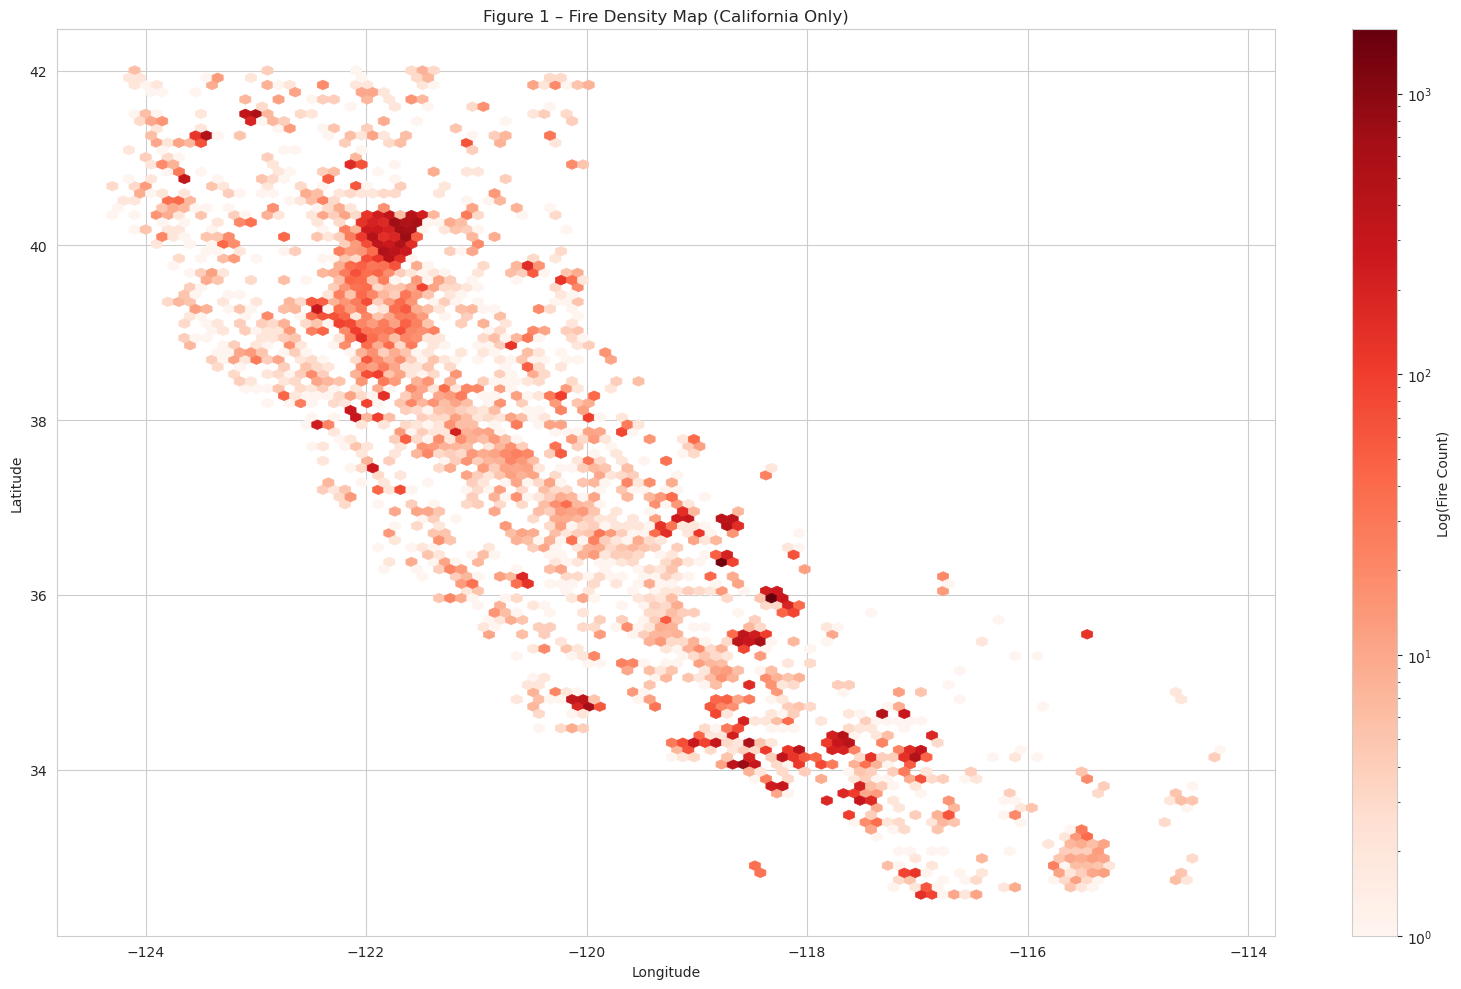

In [110]:
import matplotlib.pyplot as plt

# Define California bounding box
ca_bounds = {
    "lon_min": -124.48,
    "lon_max": -114.13,
    "lat_min": 32.53,
    "lat_max": 42.01
}

# Filter final_df to just California region
df_ca = final_df[
    (final_df['longitude'] >= ca_bounds["lon_min"]) &
    (final_df['longitude'] <= ca_bounds["lon_max"]) &
    (final_df['latitude'] >= ca_bounds["lat_min"]) &
    (final_df['latitude'] <= ca_bounds["lat_max"])
]

# Plot hexbin fire density map for California only
plt.figure(figsize=(16, 10))
hb = plt.hexbin(
    df_ca['longitude'], df_ca['latitude'],
    gridsize=100, cmap='Reds', bins='log', linewidths=0.5
)

plt.colorbar(label='Log(Fire Count)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Figure 1 – Fire Density Map (California Only)')
plt.tight_layout()
plt.show()

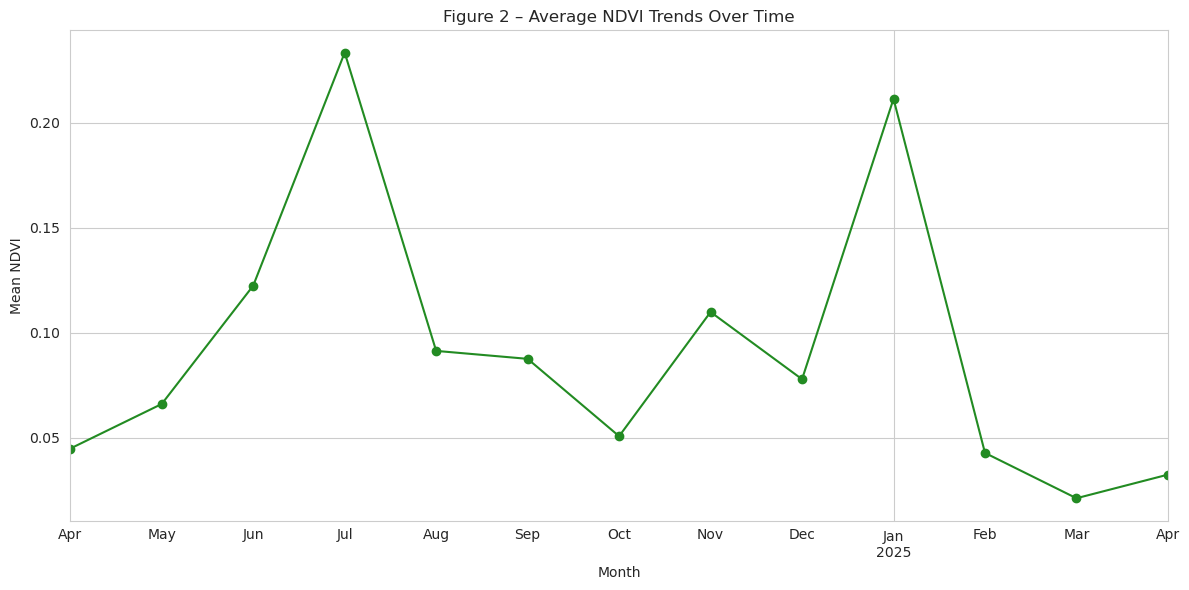

In [114]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure datetime is in datetime format
ndvi_df['date'] = pd.to_datetime(ndvi_df['datetime'])

# Extract monthly average NDVI
ndvi_df['month'] = ndvi_df['date'].dt.to_period('M')
monthly_ndvi = ndvi_df.groupby('month')['ndvi'].mean()

# Plot
plt.figure(figsize=(12, 6))
monthly_ndvi.plot(marker='o', color='forestgreen')
plt.title("Figure 2 – Average NDVI Trends Over Time")
plt.xlabel("Month")
plt.ylabel("Mean NDVI")
plt.grid(True)
plt.tight_layout()
plt.show()

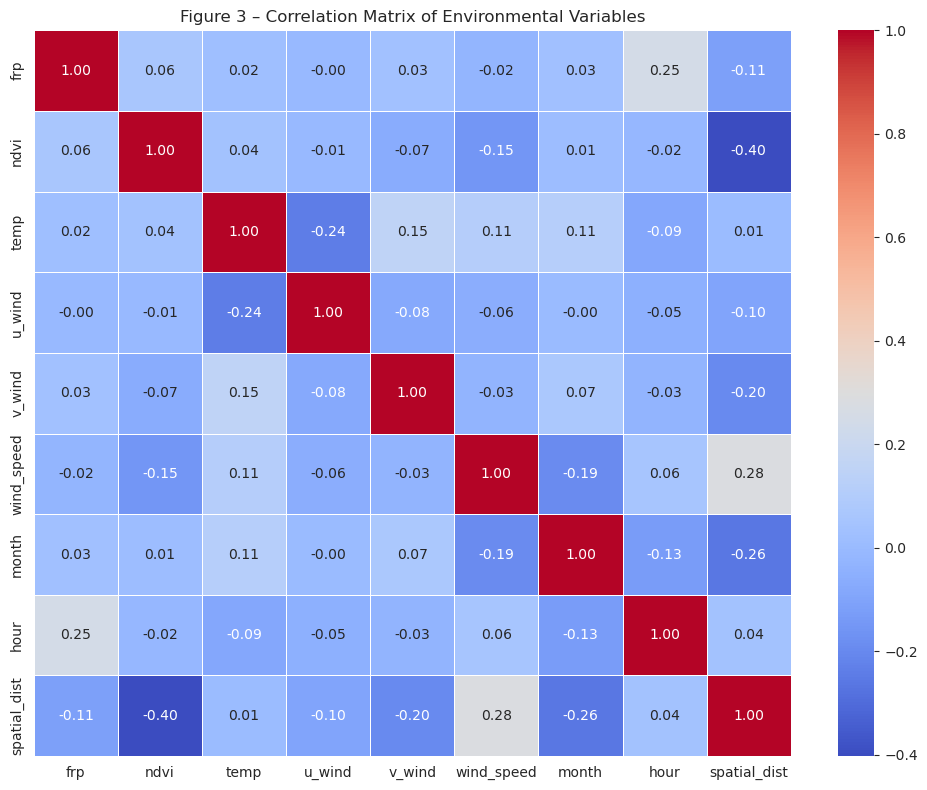

In [115]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant numeric features
correlation_features = [
    'frp', 'ndvi', 'temp', 'u_wind', 'v_wind', 'wind_speed',
    'month', 'hour', 'spatial_dist'
]

corr = final_df[correlation_features].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Figure 3 – Correlation Matrix of Environmental Variables")
plt.tight_layout()
plt.show()